#**Portfolio Optimization : Buy-and-Hold versus Momentum trading using MPT**

# Importing necessary libraries

In [ ]:
# Imported all the modules that were used in the project.

import pandas as pd
import numpy as np
from pylab import *
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

# Installed stock related packages

!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.3 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 80.6MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.6 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=b6915fba3c143b8adcd3d6905c55a9f37163e579720099f09df5c1968

# 1 - Data Preparation and EDA


## 1.1 Data Retrieval and Cleaning

I have selected 9 stocks from 3 different sectors named: Consumer Discretionary Sector, Industrial Sector, and Information Technology Sector.

### The 9 stocks that have selected are:

*   Consumer Discretionary:
1. Domino's (DPZ)
2. O'Reilly Auto Parts (ORLY)
3. Ralph Lauren Corporation (RL)

*   Industrial Sector:
4. Delta Airline (DAL)
5. General Electric (GE)
6. United Parcel Service (UPS)

*   Information Technology Sector:
7. Juniper Networks (JNPR)
8. NetApp (NTAP)
9. Qualcomm (QCOM)




In [ ]:
# Assigned the ticker list for the 9 stocks that I have selected.

tickers_list = ['DPZ', 'ORLY', 'RL', 'DAL', 'GE', 'UPS', 'JNPR', 'NTAP', 'QCOM']

# Pulled the historical price data for each stock that is mentioned in the ticker.

dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2017',end_date='12/31/2021',interval='1d') for ticker in tickers_list}

# We used stock info as si to get_data from yahoo finance.
# Used 1 day time frame for the analysis


In [ ]:
# Displayed the downloaded data.
dow_prices

# We got 1258 records for each stock for the given time period (01-01-2017 to 12-31-2021).

{'DPZ':                   open        high         low       close    adjclose  \
 2017-01-03  159.220001  159.410004  156.259995  158.360001  149.029694   
 2017-01-04  158.410004  163.330002  158.050003  162.990005  153.386932   
 2017-01-05  162.949997  164.000000  161.600006  162.770004  153.179916   
 2017-01-06  163.119995  164.399994  162.179993  163.490005  153.857498   
 2017-01-09  163.330002  165.330002  163.089996  164.509995  154.817352   
 ...                ...         ...         ...         ...         ...   
 2021-12-23  534.150024  549.140015  534.150024  545.840027  537.207886   
 2021-12-27  547.299988  561.919983  546.539978  557.210022  548.398071   
 2021-12-28  555.059998  558.710022  551.979980  557.770020  548.949280   
 2021-12-29  557.799988  565.940002  556.710022  562.400024  553.505981   
 2021-12-30  563.880005  566.940002  557.400024  557.409973  548.594788   
 
             volume ticker  
 2017-01-03  797600    DPZ  
 2017-01-04  679400    DPZ  
 201

### To construct a risk-averse portfolio, I used adjusted close column.

In [ ]:
# Extracted only the adjclose column for all the tickers.

prep_data = pd.DataFrame(dow_prices['DPZ']['adjclose']).rename(columns = {"adjclose":"DPZ"})
# Combined all the tickers that are key value pairs and converted it to a dataframe.

for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])
prep_data

,DPZ,ORLY,RL,DAL,GE,UPS,JNPR,NTAP,QCOM
2017-01-03,149.029694,280.820007,79.426552,45.714943,175.920273,94.947670,24.164579,29.833279,54.375095
2017-01-04,153.386932,282.109985,79.417778,46.842106,175.975754,94.972450,24.418051,30.060946,54.433296
2017-01-05,153.179916,282.809998,78.041862,45.945927,174.976517,95.021935,24.367357,29.816404,54.499821
2017-01-06,153.857498,281.779999,77.629974,45.899719,175.476151,95.211693,24.384256,29.706791,54.483196
2017-01-09,154.817352,279.399994,76.464386,45.908970,174.643463,94.691910,23.987143,29.706791,54.582958
...,...,...,...,...,...,...,...,...,...
2021-12-23,537.207886,679.419983,108.146881,39.299999,72.997871,203.599396,32.991367,86.803154,177.791214
2021-12-27,548.398071,692.440002,112.766312,39.000000,73.479332,206.401169,33.938671,89.398720,181.283997
2021-12-28,548.949280,696.869995,112.592720,39.630001,74.007408,205.988602,34.247993,89.322121,179.814880
2021-12-29,553.505981,708.140015,113.277443,39.160000,73.611351,205.911819,34.576645,89.245483,181.157501


In [ ]:
# Checked for NULL values in the dataframe
prep_data.isnull().sum()


DPZ     0
ORLY    0
RL      0
DAL     0
GE      0
UPS     0
JNPR    0
NTAP    0
QCOM    0
dtype: int64

In [ ]:
prep_data.shape

(1258, 9)

In [ ]:
print(prep_data.iloc[1257])

DPZ     548.594788
ORLY    701.770020
RL      113.730698
DAL      39.040001
GE       73.541458
UPS     205.240158
JNPR     34.199661
NTAP     87.818398
QCOM    177.781479
Name: 2021-12-30 00:00:00, dtype: float64


In [ ]:
# Created the new dataframe to display percentage change of each ticker from the previous day.
# Here, pct_change is considered as a return

return_data = pd.DataFrame()
for i in tickers_list:
  return_data[i] = prep_data[i].pct_change()

# Dropped the null records in the return dataframe
return_data.dropna(inplace=True)
return_data

,DPZ,ORLY,RL,DAL,GE,UPS,JNPR,NTAP,QCOM
2017-01-04,0.029237,0.004594,-0.000110,0.024656,0.000315,0.000261,0.010489,0.007631,0.001070
2017-01-05,-0.001350,0.002481,-0.017325,-0.019132,-0.005678,0.000521,-0.002076,-0.008135,0.001222
2017-01-06,0.004423,-0.003642,-0.005278,-0.001006,0.002855,0.001997,0.000694,-0.003676,-0.000305
2017-01-09,0.006239,-0.008446,-0.015015,0.000202,-0.004745,-0.005459,-0.016286,0.000000,0.001831
2017-01-10,0.011246,0.006800,0.007908,0.024955,-0.002861,-0.007406,0.000352,0.000568,-0.000305
...,...,...,...,...,...,...,...,...,...
2021-12-23,0.020586,-0.002979,0.004839,0.004344,0.009993,0.017991,0.008570,0.008120,0.007498
2021-12-27,0.020830,0.019163,0.042714,-0.007634,0.006596,0.013761,0.028714,0.029902,0.019645
2021-12-28,0.001005,0.006398,-0.001539,0.016154,0.007187,-0.001999,0.009114,-0.000857,-0.008104
2021-12-29,0.008301,0.016172,0.006081,-0.011860,-0.005352,-0.000373,0.009596,-0.000858,0.007467


In [ ]:
return_data.shape

(1257, 9)

## 1.2 Time Series Visualizations






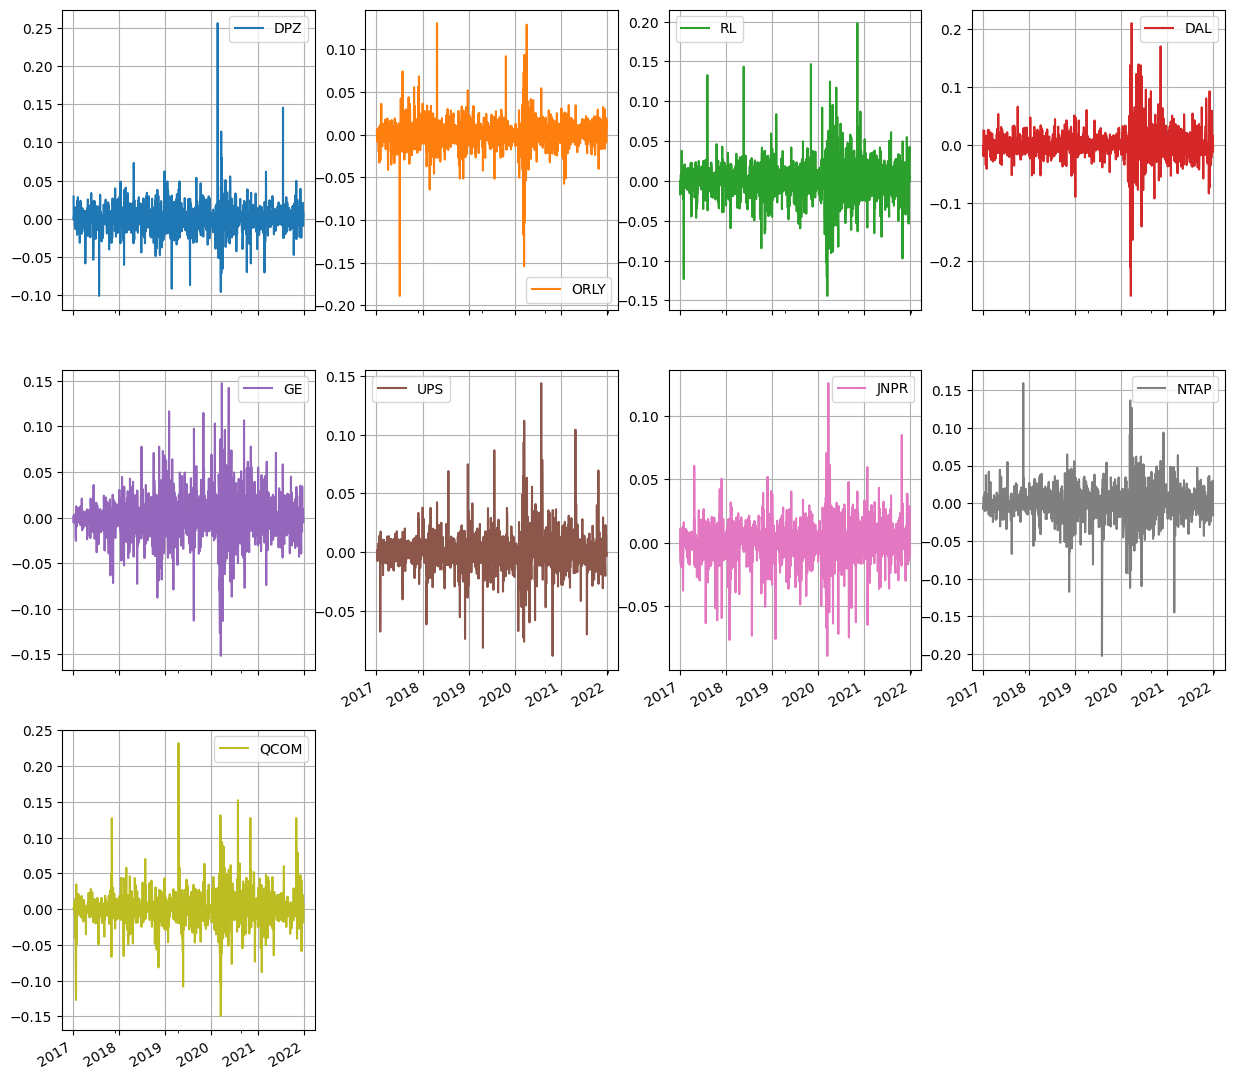

In [ ]:
# Displayed charts for all the 9 stocks

return_data.plot(subplots=True,
        grid=True,
        layout=(3,4),
         figsize=(15,15))
plt.show()

#### All stocks showed a decent move during all years, but have seen a lot of volatility during March 2020.

### 1.2.1 Visualization of Consumer Discretionary Sector

In [ ]:
return_data

,DPZ,ORLY,RL,DAL,GE,UPS,JNPR,NTAP,QCOM
2017-01-04,0.029237,0.004594,-0.000110,0.024656,0.000315,0.000261,0.010489,0.007631,0.001070
2017-01-05,-0.001350,0.002481,-0.017325,-0.019132,-0.005678,0.000521,-0.002076,-0.008135,0.001222
2017-01-06,0.004423,-0.003642,-0.005278,-0.001006,0.002855,0.001997,0.000694,-0.003676,-0.000305
2017-01-09,0.006239,-0.008446,-0.015015,0.000202,-0.004745,-0.005459,-0.016286,0.000000,0.001831
2017-01-10,0.011246,0.006800,0.007908,0.024955,-0.002861,-0.007406,0.000352,0.000568,-0.000305
...,...,...,...,...,...,...,...,...,...
2021-12-23,0.020586,-0.002979,0.004839,0.004344,0.009993,0.017991,0.008570,0.008120,0.007498
2021-12-27,0.020830,0.019163,0.042714,-0.007634,0.006596,0.013761,0.028714,0.029902,0.019645
2021-12-28,0.001005,0.006398,-0.001539,0.016154,0.007187,-0.001999,0.009114,-0.000857,-0.008104
2021-12-29,0.008301,0.016172,0.006081,-0.011860,-0.005352,-0.000373,0.009596,-0.000858,0.007467


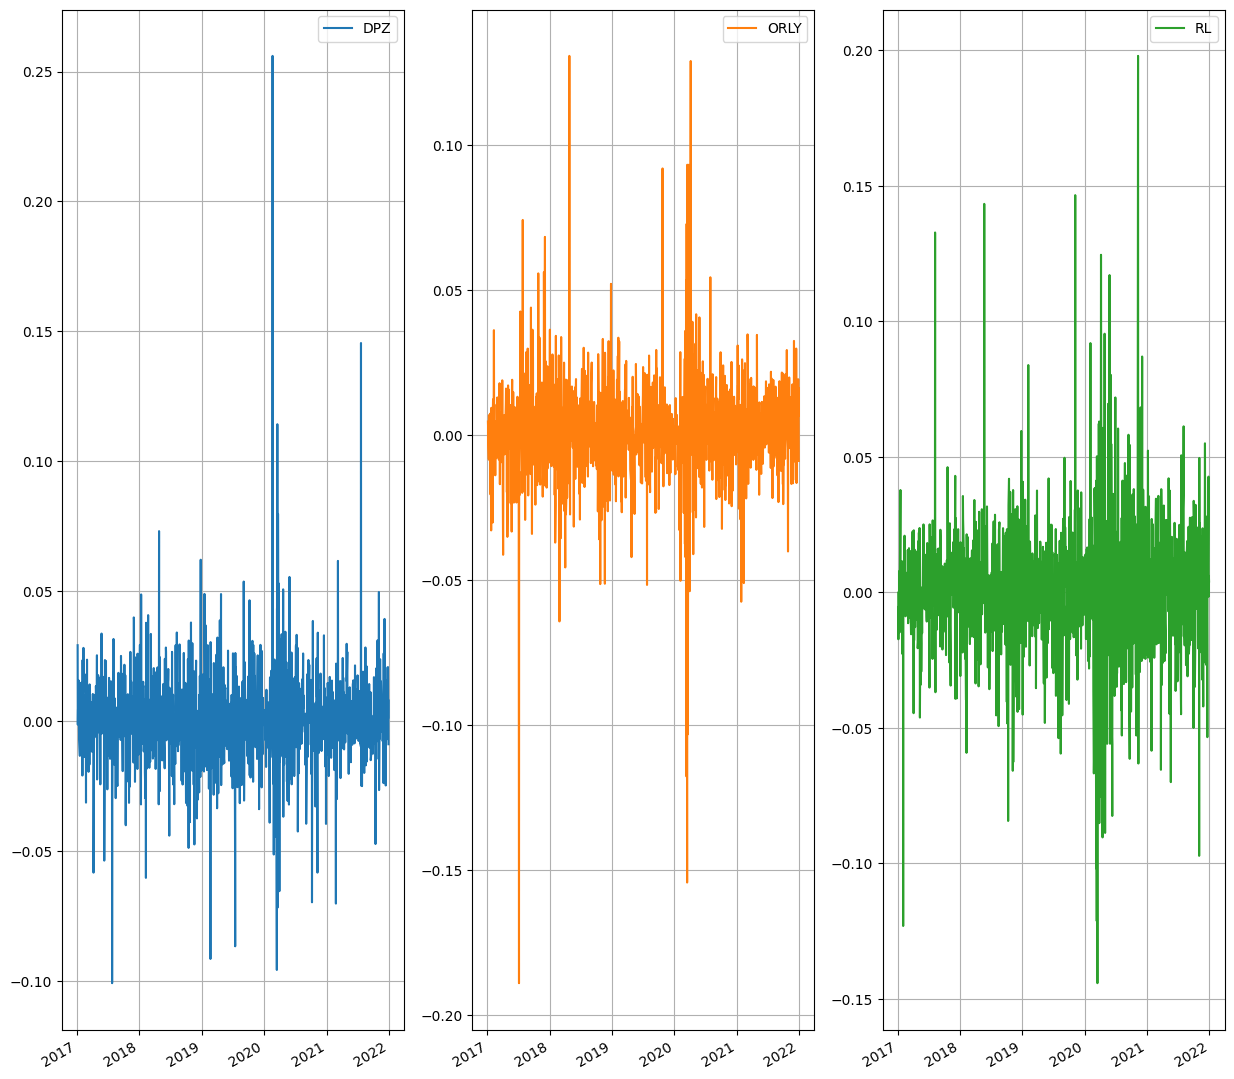

In [ ]:
# Displayed charts for Consumer Discretionary Sector

return_data[['DPZ', 'ORLY', 'RL']].plot(subplots=True,
        grid=True,
        layout=(1,3),
         figsize=(15,15))
plt.show()

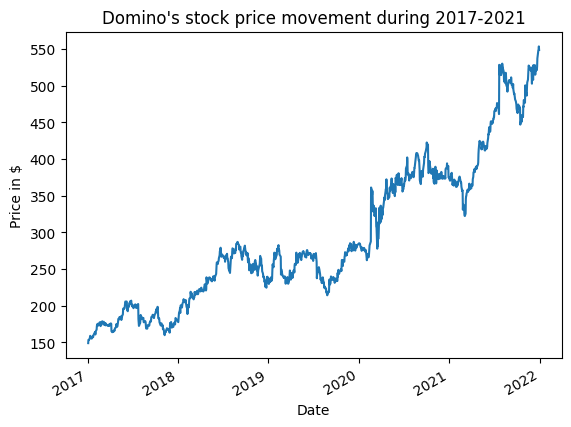

In [ ]:
# Checked the behavior of DPZ in the observation period
prep_data['DPZ'].plot()
plt.title("Domino's stock price movement during 2017-2021")
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()

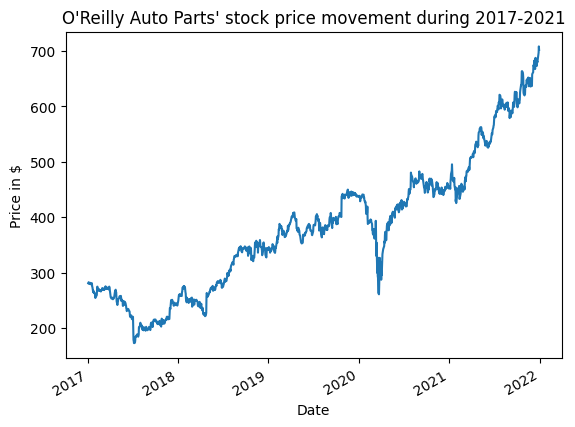

In [ ]:
# Checked the behavior of ORLY in the observation period
prep_data['ORLY'].plot()
plt.title("O'Reilly Auto Parts' stock price movement during 2017-2021")
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()

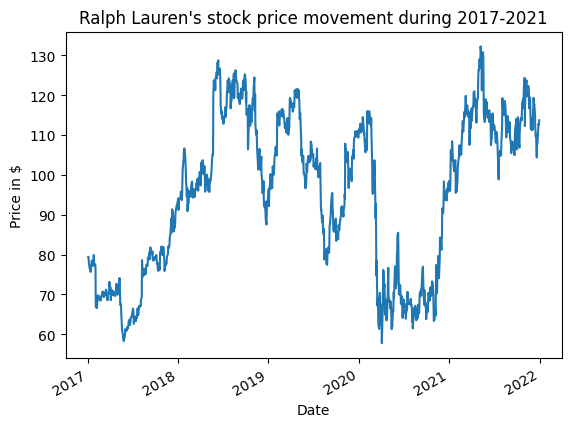

In [ ]:
# Checked the behavior of RL in the observation period

prep_data['RL'].plot()
plt.title("Ralph Lauren's stock price movement during 2017-2021")
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()

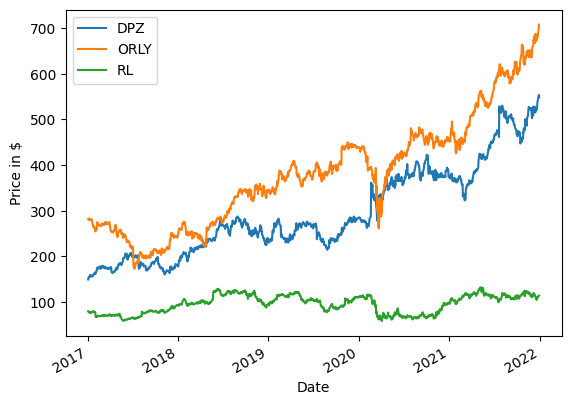

In [ ]:
# Checked the behavior of all selected stocks from Consumer Discretionary sector in the observation period

prep_data[['DPZ', 'ORLY', 'RL']].plot()
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()

### 1.2.2 Visualization of Industrial Sector

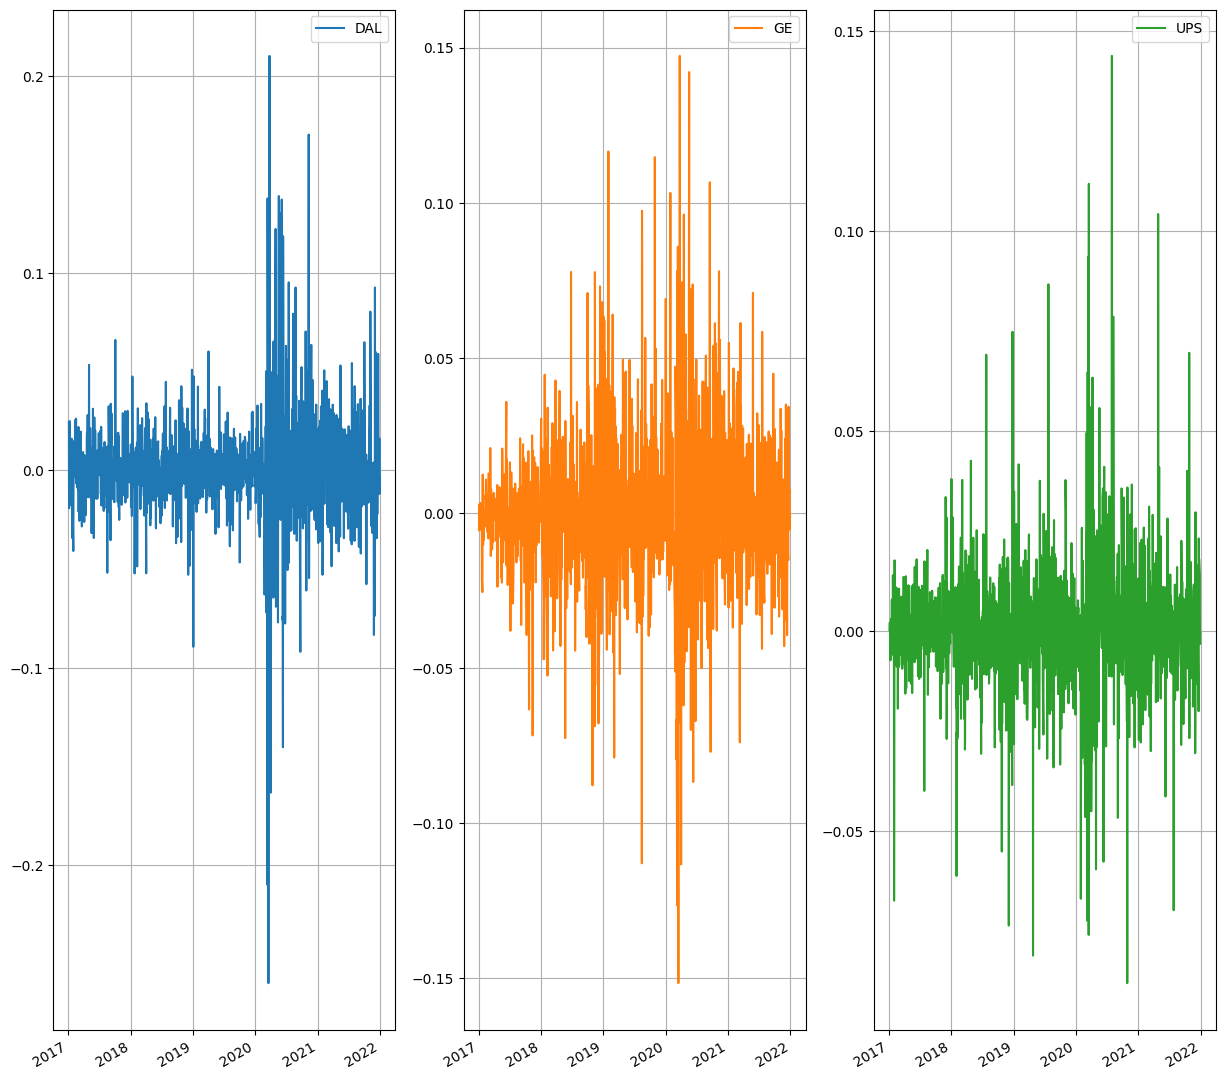

In [ ]:
# Displayed charts for Industrial Sector
return_data[['DAL', 'GE', 'UPS']].plot(subplots=True,
        grid=True,
        layout=(1,3),
         figsize=(15,15))
plt.show()

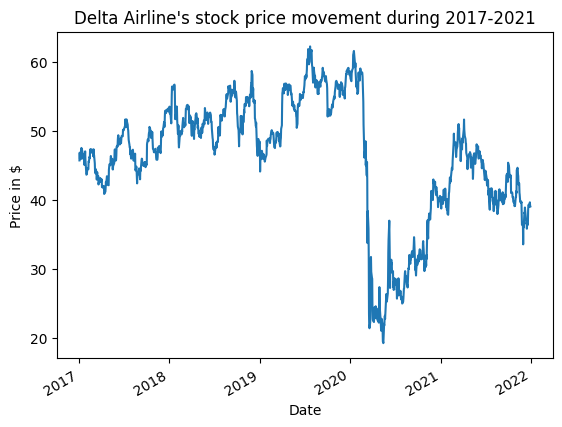

In [ ]:
# Checked the behavior of DAL in the observation period

prep_data['DAL'].plot()
plt.title("Delta Airline's stock price movement during 2017-2021")
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()

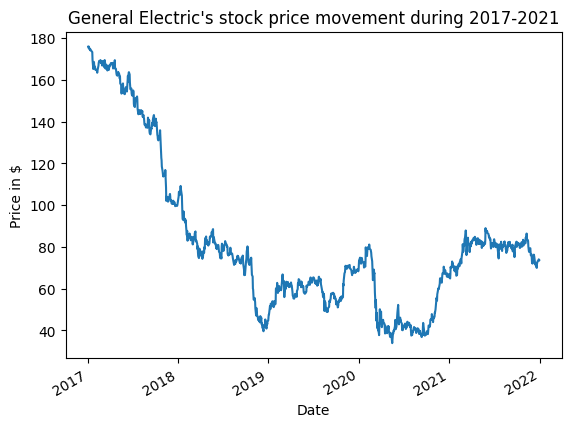

In [ ]:
# Checked the behavior of GE in the observation period

prep_data['GE'].plot()
plt.title("General Electric's stock price movement during 2017-2021")
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()

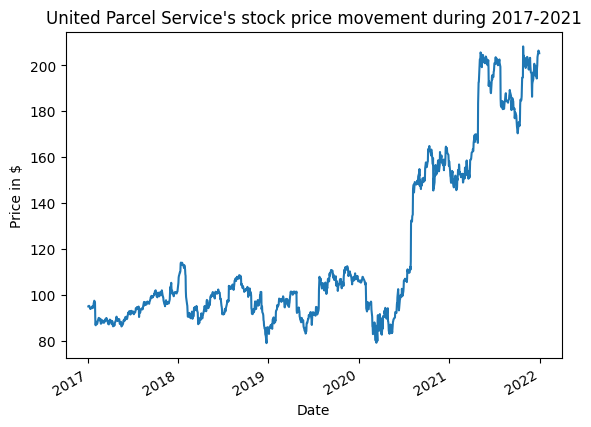

In [ ]:
# Checked the behavior of UPS in the observation period

prep_data['UPS'].plot()
plt.title("United Parcel Service's stock price movement during 2017-2021")
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()

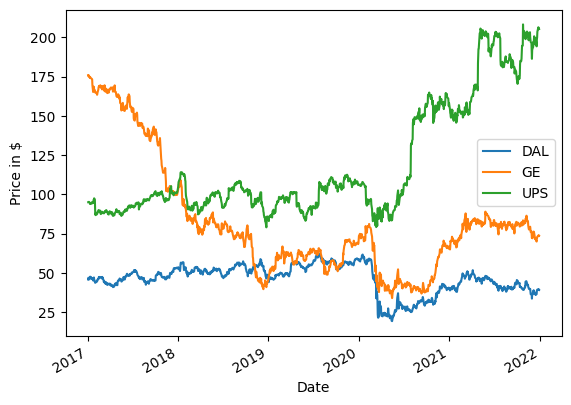

In [ ]:
# Checked the behavior of all selected stocks from communications sector in the observation period

prep_data[['DAL', 'GE', 'UPS']].plot()
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()


### 1.2.3 Visualization of Information Technology Sector

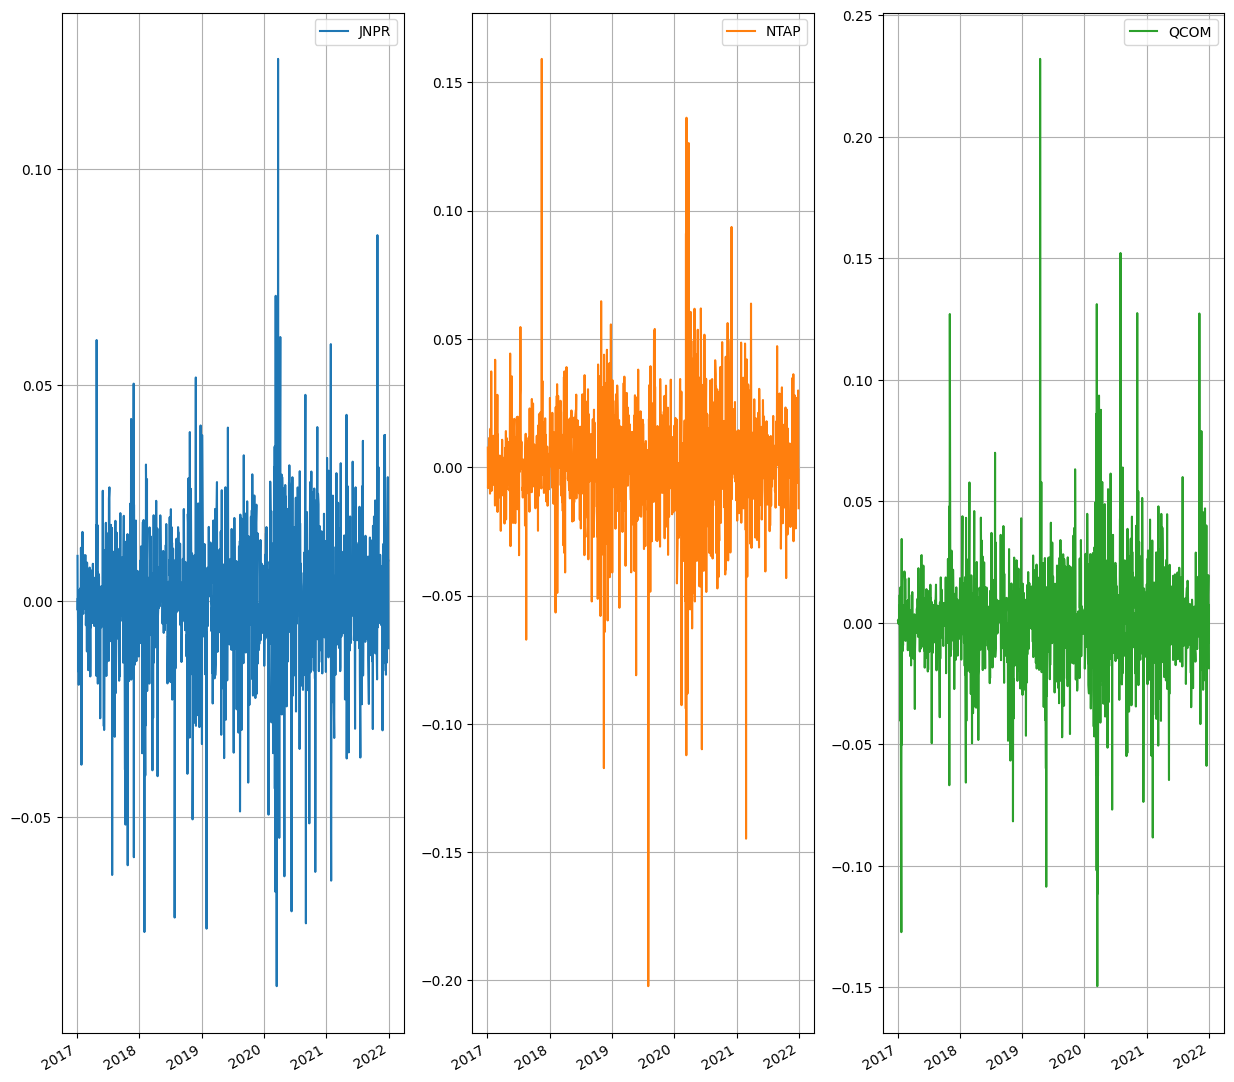

In [ ]:
# Displayed charts for Information Technology Sector
return_data[['JNPR', 'NTAP', 'QCOM']].plot(subplots=True,
        grid=True,
        layout=(1,3),
         figsize=(15,15))
plt.show()

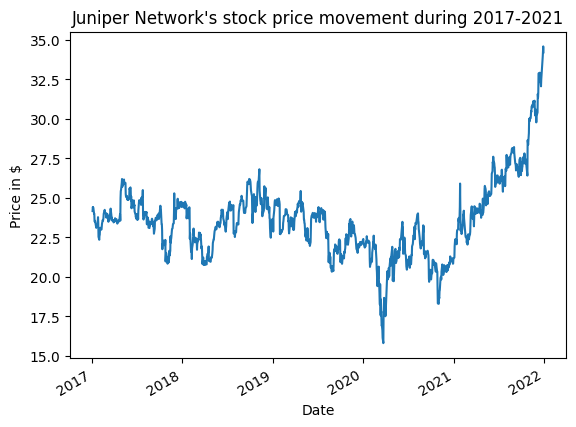

In [ ]:
# Checked the behavior of Juniper in the observation period

prep_data['JNPR'].plot()
plt.title("Juniper Network's stock price movement during 2017-2021")
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()

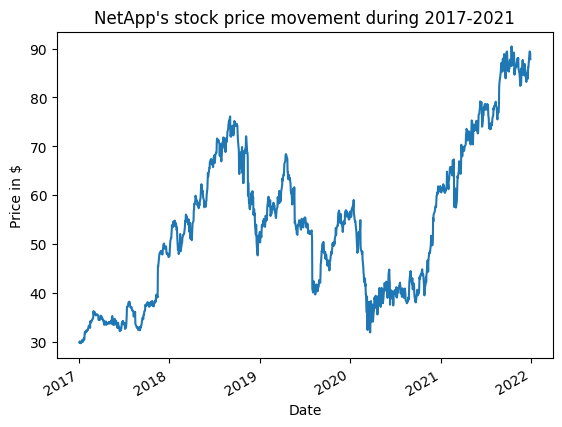

In [ ]:
# Checked the behavior of NTAP in the observation period

prep_data['NTAP'].plot()
plt.title("NetApp's stock price movement during 2017-2021")
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()

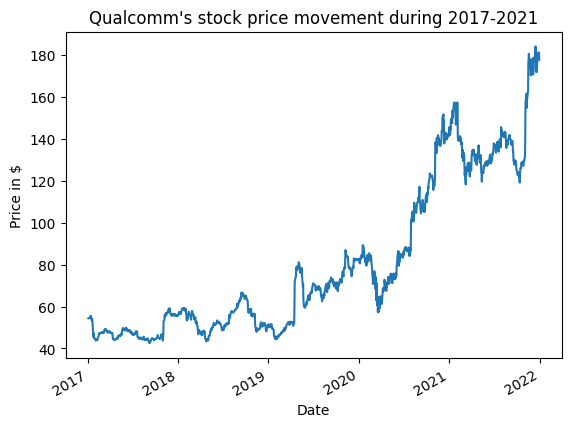

In [ ]:
# Checked the behavior of QCOM in the observation period

prep_data['QCOM'].plot()
plt.title("Qualcomm's stock price movement during 2017-2021")
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()

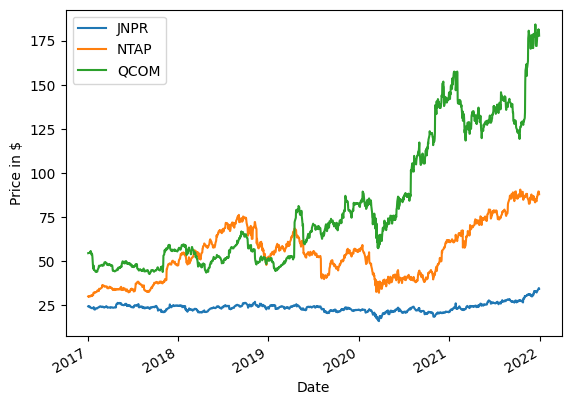

In [ ]:
# Checked the behavior of all selected stocks from Information Technology sector in the observation period

prep_data[['JNPR', 'NTAP', 'QCOM']].plot()
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()

## 1.3 - Discussion of the Plots

#### Consumer Discretionary Sector:
All of the Consumer Discretionary stocks showed a clear upward trend during most of the years. There was a sharp decline during 2020 March, later the upward trend continued.

There was a strong dip after March 2020 in both Domino's and O'Reilly's stock price, but Ralph Lauren's stock moved relatively slow.

#### Industrial Sector:
In the Industrial sector, stocks DAL and UPS gnerally followed the same pattern. After March 2020 there was a rise in all 3 Consumer Discretionary stocks, but at the end of year 2021 there was a slight dip / decline in all three stocks.

GE had a sharp decline until 2019 while DAL and UPS had a good correlation up until March 2020.

#### Information Technology Sector:
In the Information Technology sector, Qualcomm and NetAPP showed a sharp rise after March 2020, similar to Juniper Network's stocks which also showed to rise after March 2020. However, during March 2020 there was a sharp decline.

# 2 - Optimization Model



## 2.1 Model execution

In [ ]:
# Created the average return column which shows average returns of all the selected 9 stocks

Avg_Return = pd.DataFrame(np.mean(return_data) ,columns=["Avg_Return"])
print(Avg_Return)

      Avg_Return
DPZ     0.001222
ORLY    0.000907
RL      0.000615
DAL     0.000265
GE     -0.000348
UPS     0.000762
JNPR    0.000423
NTAP    0.001131
QCOM    0.001224


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
# Created the standard deviation of the return column which shows standard deviation returns of all the selected 9 stocks

Std_Dev_Return = pd.DataFrame(np.std(return_data) ,columns=["Std_Dev_Return"])
print(Std_Dev_Return)

      Std_Dev_Return
DPZ         0.019437
ORLY        0.018773
RL          0.025713
DAL         0.027805
GE          0.026305
UPS         0.017314
JNPR        0.017116
NTAP        0.023162
QCOM        0.023869


In [ ]:
# Calculated the covariance matrix

Covariance_matrix = return_data.cov()
Covariance_matrix

,DPZ,ORLY,RL,DAL,GE,UPS,JNPR,NTAP,QCOM
DPZ,0.000378,0.000087,0.000045,0.000025,0.000036,0.000075,0.000070,0.000075,0.000104
ORLY,0.000087,0.000353,0.000163,0.000146,0.000128,0.000130,0.000099,0.000140,0.000151
RL,0.000045,0.000163,0.000662,0.000351,0.000293,0.000148,0.000161,0.000237,0.000175
DAL,0.000025,0.000146,0.000351,0.000774,0.000367,0.000127,0.000161,0.000272,0.000191
GE,0.000036,0.000128,0.000293,0.000367,0.000692,0.000151,0.000155,0.000219,0.000180
UPS,0.000075,0.000130,0.000148,0.000127,0.000151,0.000300,0.000108,0.000165,0.000168
JNPR,0.000070,0.000099,0.000161,0.000161,0.000155,0.000108,0.000293,0.000184,0.000148
NTAP,0.000075,0.000140,0.000237,0.000272,0.000219,0.000165,0.000184,0.000537,0.000217
QCOM,0.000104,0.000151,0.000175,0.000191,0.000180,0.000168,0.000148,0.000217,0.000570


In [ ]:
# Calculated the correlation matrix

Corr_matrix = return_data.corr()
Corr_matrix

,DPZ,ORLY,RL,DAL,GE,UPS,JNPR,NTAP,QCOM
DPZ,1.000000,0.239405,0.089273,0.045736,0.070677,0.222764,0.209071,0.167477,0.222935
ORLY,0.239405,1.000000,0.336900,0.280136,0.259176,0.400349,0.309010,0.322368,0.336583
RL,0.089273,0.336900,1.000000,0.490790,0.433492,0.333142,0.364885,0.398006,0.284565
DAL,0.045736,0.280136,0.490790,1.000000,0.501740,0.264153,0.337150,0.421376,0.288303
GE,0.070677,0.259176,0.433492,0.501740,1.000000,0.332117,0.343661,0.359628,0.285883
UPS,0.222764,0.400349,0.333142,0.264153,0.332117,1.000000,0.364875,0.410402,0.405280
JNPR,0.209071,0.309010,0.364885,0.337150,0.343661,0.364875,1.000000,0.464940,0.361714
NTAP,0.167477,0.322368,0.398006,0.421376,0.359628,0.410402,0.464940,1.000000,0.392430
QCOM,0.222935,0.336583,0.284565,0.288303,0.285883,0.405280,0.361714,0.392430,1.000000


### Nonlinear optimization model

In [ ]:
# Created a new dataframe for the Covariance of the return data
df_cov = return_data.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n')

# Created the average of each stock which can be considered as the objective function COEFFICIENTS

df_return = return_data.mean()
print('Average Return:')
print(df_return)

Covariance Matrix:
           DPZ      ORLY        RL       DAL        GE       UPS      JNPR  \
DPZ   0.000378  0.000087  0.000045  0.000025  0.000036  0.000075  0.000070   
ORLY  0.000087  0.000353  0.000163  0.000146  0.000128  0.000130  0.000099   
RL    0.000045  0.000163  0.000662  0.000351  0.000293  0.000148  0.000161   
DAL   0.000025  0.000146  0.000351  0.000774  0.000367  0.000127  0.000161   
GE    0.000036  0.000128  0.000293  0.000367  0.000692  0.000151  0.000155   
UPS   0.000075  0.000130  0.000148  0.000127  0.000151  0.000300  0.000108   
JNPR  0.000070  0.000099  0.000161  0.000161  0.000155  0.000108  0.000293   
NTAP  0.000075  0.000140  0.000237  0.000272  0.000219  0.000165  0.000184   
QCOM  0.000104  0.000151  0.000175  0.000191  0.000180  0.000168  0.000148   

          NTAP      QCOM  
DPZ   0.000075  0.000104  
ORLY  0.000140  0.000151  
RL    0.000237  0.000175  
DAL   0.000272  0.000191  
GE    0.000219  0.000180  
UPS   0.000165  0.000168  
JNPR  0.000

### Creating a ConcreteModel class to define the variables

In [ ]:
m = ConcreteModel()

# Defined variables for the concrete model
# each one is a stock  ['DPZ', 'ORLY', 'RL', 'DAL', 'GE', 'UPS', 'JNPR', 'NTAP', 'QCOM']
m.DPZ = Var(within=NonNegativeReals, bounds=(0,1))
m.ORLY = Var(within=NonNegativeReals, bounds=(0,1))
m.RL = Var(within=NonNegativeReals, bounds=(0,1))
m.DAL = Var(within=NonNegativeReals, bounds=(0,1))
m.GE = Var(within=NonNegativeReals, bounds=(0,1))
m.UPS = Var(within=NonNegativeReals, bounds=(0,1))
m.JNPR = Var(within=NonNegativeReals, bounds=(0,1))
m.NTAP = Var(within=NonNegativeReals, bounds=(0,1))
m.QCOM = Var(within=NonNegativeReals, bounds=(0,1))

### Defining the Objective function, constraints & return

In [ ]:
# Declared objective function
m.objective = Objective(expr =
                        m.DPZ*df_return[0] +
                        m.ORLY*df_return[1] +
                        m.RL*df_return[2] +
                        m.DAL*df_return[3] +
                        m.GE*df_return[4]+
                        m.UPS*df_return[5]+
                        m.JNPR*df_return[6]+
                        m.NTAP*df_return[7]+
                        m.QCOM*df_return[8],
                        sense=maximize) # yes, I want to MAX our returns!

# declare constraints
# 1. Sum of all proportions = 1
m.sum_proportions = Constraint(expr = m.DPZ + m.ORLY + m.RL + m.DAL + m.GE + m.UPS + m.JNPR + m.NTAP + m.QCOM == 1)

# 2. Minimum return should be 0.015 or 1.5%
#m.return_floor = Constraint(expr = m.objective >= 0.015)

# 3. Set minimum risk: WE ARE INCLUDING THIS CONSTRAINT NOW FOR TECHNICAL REASONS (see below)
# YOU CAN (and should!) IGNORE IT FOR NOW!
# It is just initializing the constraint
m.total_risk = Constraint(expr =  m.DPZ + m.ORLY + m.RL + m.DAL + m.GE + m.UPS + m.JNPR + m.NTAP + m.QCOM >= 0.0)

In [ ]:
# Created a table for calculating the risk
# Risk Calculation

def calc_risk(m):
  variables = m.DPZ, m.ORLY, m.RL, m.DAL, m.GE, m.UPS, m.JNPR, m.NTAP, m.QCOM
  tickers = ['DPZ', 'ORLY', 'RL', 'DAL', 'GE', 'UPS', 'JNPR', 'NTAP', 'QCOM']
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers[i],tickers[j]]*variables[j]
  return risk_exp

# Used this expression to compute the risk
expr_risk = calc_risk(m)

max_risk = 0.0005

# Required sequence of risk levels

risk_limits = np.arange(0.000135, 0.000375, 0.000002)
risk_limits

array([0.000135, 0.000137, 0.000139, 0.000141, 0.000143, 0.000145,
       0.000147, 0.000149, 0.000151, 0.000153, 0.000155, 0.000157,
       0.000159, 0.000161, 0.000163, 0.000165, 0.000167, 0.000169,
       0.000171, 0.000173, 0.000175, 0.000177, 0.000179, 0.000181,
       0.000183, 0.000185, 0.000187, 0.000189, 0.000191, 0.000193,
       0.000195, 0.000197, 0.000199, 0.000201, 0.000203, 0.000205,
       0.000207, 0.000209, 0.000211, 0.000213, 0.000215, 0.000217,
       0.000219, 0.000221, 0.000223, 0.000225, 0.000227, 0.000229,
       0.000231, 0.000233, 0.000235, 0.000237, 0.000239, 0.000241,
       0.000243, 0.000245, 0.000247, 0.000249, 0.000251, 0.000253,
       0.000255, 0.000257, 0.000259, 0.000261, 0.000263, 0.000265,
       0.000267, 0.000269, 0.000271, 0.000273, 0.000275, 0.000277,
       0.000279, 0.000281, 0.000283, 0.000285, 0.000287, 0.000289,
       0.000291, 0.000293, 0.000295, 0.000297, 0.000299, 0.000301,
       0.000303, 0.000305, 0.000307, 0.000309, 0.000311, 0.000

In [ ]:
len(risk_limits)

121

In [ ]:
# Updated risk constraint for each limit

# We created an empty key-value pair called param_analysis having risk as "key" and returns as "value"
# key=risk, value =stock allocations

param_analysis = {}
returns = {}

for r in risk_limits:
  # Removed and recalculated the risk in each iteration
  m.del_component(m.total_risk)

  # The left hand side remains unchanged, and then I modified the risk threshold
  m.total_risk = Constraint(expr = expr_risk <= r)

  # Ran the solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m).write()

  # Stored the allocation proportions
  param_analysis[r] = [m.DPZ(), m.ORLY(), m.RL(), m.DAL(), m.GE(), m.UPS(), m.JNPR(), m.NTAP(), m.QCOM()]

  # Stored the returns
  returns[r] = m.DPZ()*df_return[0] + m.ORLY()*df_return[1] + m.RL()*df_return[2] +  m.DAL()*df_return[3] + m.GE()*df_return[4] + m.UPS()*df_return[5] + m.JNPR()*df_return[6] + m.NTAP()*df_return[7] + m.QCOM()*df_return[8]

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 0.952472448348999
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of sol

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.024944543838500977
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 0.9418206214904785
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 0.9387338161468506
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.024930477142333984
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.018822908401489258
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.982429027557373
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of sol

In [ ]:
from pyomo.opt import SolverStatus, TerminationCondition

# Updated risk contraint for each limit
# key = risk, value = stock allocations

param_analysis = {}
returns = {}

for r in risk_limits:
  # Removed constraints to avoid error messages
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  # Ran the solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m)

  # Solution is not feasible, so I ignored this run
  if result.solver.termination_condition == TerminationCondition.infeasible:
    continue

  result = result.write()

  # Stored the allocation proportions
  param_analysis[r] = [m.DPZ(), m.ORLY(), m.RL(), m.DAL(), m.GE(), m.UPS(), m.JNPR(), m.NTAP(), m.QCOM()]
  # Stored the returns
  returns[r] = m.DPZ()*df_return[0] + m.ORLY()*df_return[1] + m.RL()*df_return[2] +  m.DAL()*df_return[3] + m.GE()*df_return[4] + m.UPS()*df_return[5] + m.JNPR()*df_return[6] + m.NTAP()*df_return[7] + m.QCOM()*df_return[8]


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 0.9293277263641357
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 0.9437000751495361
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.9410285949707031
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

In [ ]:
# Checked the dictionary
print(param_analysis)

# I observed the key:value for respective risk:reward starting from 0.0135%

{0.000139: [0.25478120258311926, 0.16530192161855253, 0.017702515353587807, 0.03573010534029359, 0.03668634862622279, 0.22113567489631888, 0.2572463120100158, 0.0, 0.011415926444732154], 0.00014099999999999998: [0.2547812027414636, 0.16530192171986396, 0.01770251536675645, 0.03573010536107682, 0.03668634863793258, 0.2211356750289581, 0.25724631215603294, 0.0, 0.011415926458630756], 0.00014699999999999997: [0.2547751998063335, 0.16530363425125424, 0.01770203149976006, 0.035730168448865264, 0.03668636284146621, 0.2211381255962549, 0.2572494193566355, 0.0, 0.011415067790093483], 0.00014899999999999996: [0.2547812033866427, 0.16530192212997377, 0.017702515424501217, 0.035730105443074534, 0.036686348664711474, 0.22113567556035296, 0.25724631272482423, 0.0, 0.011415926528102914], 0.00015099999999999996: [0.2748395151042137, 0.17257419817872105, 0.024364595984715347, 0.03003195897837218, 0.0005720652557156102, 0.21757230443726347, 0.22282546712075235, 0.02463304237859627, 0.03258685256165011]

## 2.2 Plot with allocation of the stocks

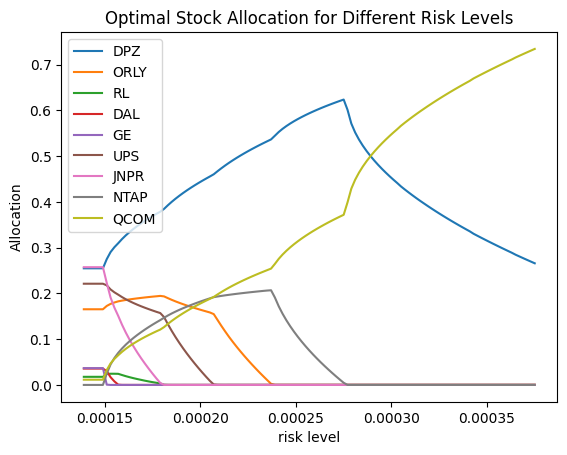

In [ ]:
# Generated the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = ['DPZ', 'ORLY', 'RL', 'DAL', 'GE', 'UPS', 'JNPR', 'NTAP', 'QCOM']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.xlabel('risk level')
plt.ylabel('Allocation')
plt.show()

In [ ]:
# Converted dict_keys to a risk list
risk = list(returns.keys())
print(risk)

# Converted dict_keys to a reward list
reward = list(returns.values())
print(reward)

[0.000139, 0.00014099999999999998, 0.00014699999999999997, 0.00014899999999999996, 0.00015099999999999996, 0.00015299999999999995, 0.00015499999999999995, 0.00015699999999999994, 0.00015899999999999993, 0.00016099999999999993, 0.00016299999999999992, 0.00016499999999999992, 0.0001669999999999999, 0.0001689999999999999, 0.0001709999999999999, 0.0001729999999999999, 0.0001749999999999999, 0.00017699999999999988, 0.00017899999999999988, 0.00018099999999999987, 0.00018299999999999987, 0.00018499999999999986, 0.00018699999999999986, 0.00018899999999999985, 0.00019099999999999985, 0.00019299999999999984, 0.00019499999999999983, 0.00019699999999999983, 0.00019899999999999982, 0.00020099999999999982, 0.0002029999999999998, 0.0002049999999999998, 0.0002069999999999998, 0.0002089999999999998, 0.0002109999999999998, 0.00021299999999999978, 0.00021499999999999978, 0.00021699999999999977, 0.00021899999999999977, 0.00022099999999999976, 0.00022299999999999976, 0.00022499999999999975, 0.0002269999999

## 2.3 Plot with efficient frontier

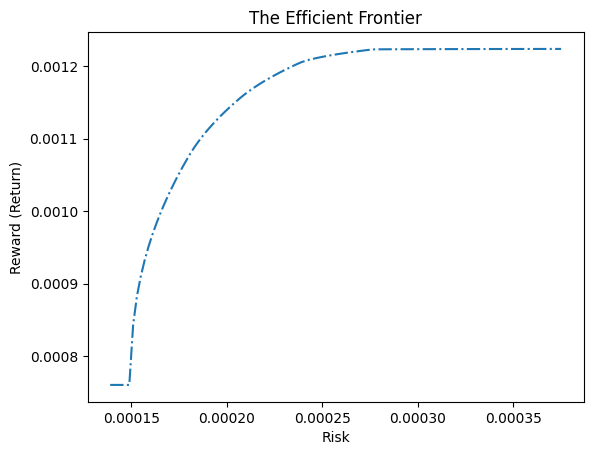

In [ ]:
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

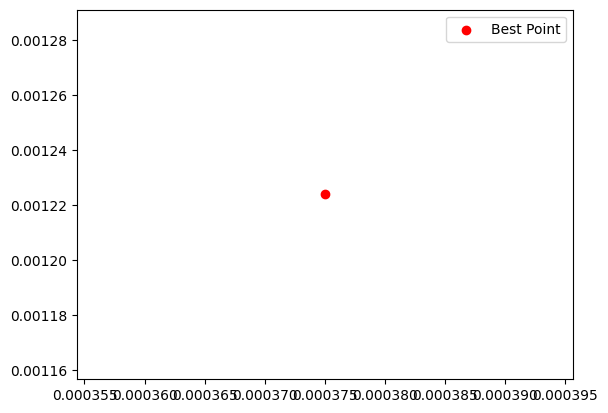

The best point (maximum Sharpe ratio) is at risk {best_risk} and reward {best_reward}.


In [ ]:
# Calculates the optimal portfolio allocation by maximizing the Sharpe ratio to identify the best point on the efficient frontier.
risk = np.array(risk)
reward = np.array(reward)

# Risk-free rate
risk_free_rate = 0.03 # The risk-free rate is set to 3%

# Calculate Sharpe ratios
sharpe_ratios = (reward - risk_free_rate) / risk

# Find the index of the maximum Sharpe ratio
best_idx = np.argmax(sharpe_ratios)

# Find the best risk and reward values
best_risk = risk[best_idx]
best_reward = reward[best_idx]
# Plot the best point
plt.scatter(best_risk, best_reward, c='red', marker='o', label='Best Point')

plt.legend()
plt.show()

print("The best point (maximum Sharpe ratio) is at risk {best_risk} and reward {best_reward}.")

## 2.4 Portfolio selection

In [ ]:
#for the risk level 0.00037499999999999936 reward is maximum
print(param_analysis.get('0.00037499999999999936'))
print(param_analysis.loc[0.00037499999999999936])


None
DPZ     0.265779
ORLY    0.000008
RL      0.000004
DAL     0.000003
GE      0.000002
UPS     0.000005
JNPR    0.000003
NTAP    0.000027
QCOM    0.734169
Name: 0.00037499999999999936, dtype: float64


In [ ]:
# Create a dictionary with the optimal allocation for the chosen stocks
opt_alloc = {'DPZ': 0.265779, 'QCOM': 0.734169, 'NTAP': 0.000027}

# Convert it to a dataframe
optimal_weight = pd.DataFrame(opt_alloc, index=[0])

# Rename the columns for better understanding
optimal_weight.columns = ['DPZ (Domino\'s Pizza)', 'QCOM (Qualcomm)', 'NTAP (NetApp)']

# Display the DataFrame
print(optimal_weight)



   DPZ (Domino's Pizza)  QCOM (Qualcomm)  NTAP (NetApp)
0              0.265779         0.734169       0.000027


The top 3 stocks with the highest allocation are:

Domino's (DPZ): 0.265779

Qualcomm (QCOM): 0.734169

NetApp (NTAP): 0.000027

# 3 - Analysis

## 3.0 - Data Preparation before implementing Buy-and-Hold strategy for the MPT portfolio

In [ ]:
tickers_opt = ['DPZ', 'QCOM', 'NTAP']

Daily Buy-Hold 2017 to 2021


In [ ]:
# Pulled historical price for the 3 stocks (daily data) in our portfolio
my_Stocks = {ticker : si.get_data(ticker,start_date = '2017-01-01',end_date= '2021-12-31',interval='1d') for ticker in tickers_opt}

# We used stock info as si to get_data from yahoo finance
my_Stocks

{'DPZ':                   open        high         low       close    adjclose  \
 2017-01-03  159.220001  159.410004  156.259995  158.360001  149.029709   
 2017-01-04  158.410004  163.330002  158.050003  162.990005  153.386948   
 2017-01-05  162.949997  164.000000  161.600006  162.770004  153.179901   
 2017-01-06  163.119995  164.399994  162.179993  163.490005  153.857513   
 2017-01-09  163.330002  165.330002  163.089996  164.509995  154.817368   
 ...                ...         ...         ...         ...         ...   
 2021-12-23  534.150024  549.140015  534.150024  545.840027  537.207825   
 2021-12-27  547.299988  561.919983  546.539978  557.210022  548.398071   
 2021-12-28  555.059998  558.710022  551.979980  557.770020  548.949219   
 2021-12-29  557.799988  565.940002  556.710022  562.400024  553.505920   
 2021-12-30  563.880005  566.940002  557.400024  557.409973  548.594849   
 
             volume ticker  
 2017-01-03  797600    DPZ  
 2017-01-04  679400    DPZ  
 201

Monthly Buy-Hold only 2022

In [ ]:
# Pulled historical price for the 3 stocks (daily data) in our portfolio
my_Stocks1 = {ticker : si.get_data(ticker,start_date = '2022-01-01',end_date= '2022-12-02',interval='1mo') for ticker in tickers_opt}

# We used stock info as si to get_data from yahoo finance
my_Stocks1

{'DPZ':                   open        high         low       close    adjclose  \
 2022-01-01  562.780029  564.729980  421.380005  454.649994  447.459961   
 2022-02-01  456.040009  463.720001  390.339996  432.209991  425.374817   
 2022-03-01  394.500000  448.989990  381.239990  407.010010  400.573364   
 2022-04-01  405.359985  405.779999  335.630005  338.000000  333.604492   
 2022-05-01  341.820007  366.519989  321.149994  363.170013  358.447205   
 2022-06-01  364.970001  401.109985  359.049988  389.709991  384.642059   
 2022-07-01  392.619995  426.440002  380.750000  392.109985  388.132507   
 2022-08-01  392.309998  417.230011  370.899994  371.859985  368.087921   
 2022-09-01  370.160004  378.359985  310.070007  310.200012  307.053406   
 2022-10-01  311.149994  339.200012  299.410004  332.239990  329.905518   
 2022-11-01  334.149994  395.000000  330.109985  388.730011  385.998627   
 2022-12-01  391.220001  392.040009  341.549988  346.399994  343.966034   
 
               v

In [ ]:
len(my_Stocks)

3

In [ ]:
# Extracted only close price for all 3 stocks and renamed it
portfolio_0 = pd.DataFrame()

# Combined all the tickers
for i in tickers_opt[0:]:
  portfolio_0[i] = pd.DataFrame(my_Stocks1[i]['close'])

In [ ]:
portfolio_0

,DPZ,QCOM,NTAP
2022-01-01,454.649994,175.759995,86.510002
2022-02-01,432.209991,171.990005,78.379997
2022-03-01,407.010010,152.820007,83.000000
2022-04-01,338.000000,139.690002,73.250000
2022-05-01,363.170013,143.220001,71.949997
2022-06-01,389.709991,127.739998,65.239998
2022-07-01,392.109985,145.059998,71.330002
2022-08-01,371.859985,132.270004,72.129997
2022-09-01,310.200012,112.980003,61.849998
2022-10-01,332.239990,117.660004,69.269997


In [ ]:
# Renamed the column names using the list
portfolio_0.columns = ['m_DPZ_close', 'm_QCOM_close', 'm_NTAP_close']
portfolio_0.head(5)


,m_DPZ_close,m_QCOM_close,m_NTAP_close
2022-01-01,454.649994,175.759995,86.510002
2022-02-01,432.209991,171.990005,78.379997
2022-03-01,407.010010,152.820007,83.000000
2022-04-01,338.000000,139.690002,73.250000
2022-05-01,363.170013,143.220001,71.949997


In [ ]:
portfolio_0.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2022-01-01 to 2022-12-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   m_DPZ_close   12 non-null     float64
 1   m_QCOM_close  12 non-null     float64
 2   m_NTAP_close  12 non-null     float64
dtypes: float64(3)
memory usage: 384.0 bytes


In [ ]:
portfolio_0

,m_DPZ_close,m_QCOM_close,m_NTAP_close
2022-01-01,454.649994,175.759995,86.510002
2022-02-01,432.209991,171.990005,78.379997
2022-03-01,407.010010,152.820007,83.000000
2022-04-01,338.000000,139.690002,73.250000
2022-05-01,363.170013,143.220001,71.949997
2022-06-01,389.709991,127.739998,65.239998
2022-07-01,392.109985,145.059998,71.330002
2022-08-01,371.859985,132.270004,72.129997
2022-09-01,310.200012,112.980003,61.849998
2022-10-01,332.239990,117.660004,69.269997


In [ ]:
# Extracted only close price for all 3 stocks and renamed it
portfolio = pd.DataFrame()

# Combined all the tickers
for i in tickers_opt[0:]:
  portfolio[i] = pd.DataFrame(my_Stocks[i]['close'])

In [ ]:
portfolio

,DPZ,QCOM,NTAP
2017-01-03,158.360001,65.400002,35.570000
2017-01-04,162.990005,65.470001,35.650002
2017-01-05,162.770004,65.550003,35.360001
2017-01-06,163.490005,65.529999,35.230000
2017-01-09,164.509995,65.650002,35.230000
...,...,...,...
2021-12-23,545.840027,182.740005,90.629997
2021-12-27,557.210022,186.330002,93.339996
2021-12-28,557.770020,184.820007,93.260002
2021-12-29,562.400024,186.199997,93.180000


In [ ]:
# Renamed the column names using the list
portfolio.columns = ['DPZ_close', 'QCOM_close', 'NTAP_close']
portfolio.head(5)


,DPZ_close,QCOM_close,NTAP_close
2017-01-03,158.360001,65.400002,35.570000
2017-01-04,162.990005,65.470001,35.650002
2017-01-05,162.770004,65.550003,35.360001
2017-01-06,163.490005,65.529999,35.230000
2017-01-09,164.509995,65.650002,35.230000


In [ ]:
portfolio.info()
# There are no NULL values for the data, so we can move forward with the dataset

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2017-01-03 to 2021-12-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DPZ_close   1258 non-null   float64
 1   QCOM_close  1258 non-null   float64
 2   NTAP_close  1258 non-null   float64
dtypes: float64(3)
memory usage: 39.3 KB


In [ ]:
portfolio.describe()


,DPZ_close,QCOM_close,NTAP_close
count,1258.000000,1258.000000,1258.000000
mean,305.695644,87.536709,60.588164
std,100.086129,36.269804,16.092804
min,158.360001,49.400002,35.230000
25%,230.447498,57.452499,44.362500
50%,279.895004,73.340000,60.799999
75%,383.095001,119.535000,72.950001
max,562.400024,189.279999,94.419998


In [ ]:
# Observed a data leakage due to the 9th day
portfolio['DPZ-9-day'] = portfolio['DPZ_close'].rolling(9).mean()
portfolio['DPZ-21-day'] = portfolio['DPZ_close'].rolling(21).mean()
portfolio['QCOM-9-day'] = portfolio['QCOM_close'].rolling(9).mean()
portfolio['QCOM-21-day'] = portfolio['QCOM_close'].rolling(21).mean()
portfolio['NTAP-9-day'] = portfolio['NTAP_close'].rolling(9).mean()
portfolio['NTAP-21-day'] = portfolio['NTAP_close'].rolling(21).mean()


In [ ]:
portfolio.head(10)

# Assumed the dataframe "portfolio" as the main dataframe and then derived strategies from this dataframe.

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day
2017-01-03,158.360001,65.400002,35.570000,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,162.990005,65.470001,35.650002,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,162.770004,65.550003,35.360001,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,163.490005,65.529999,35.230000,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,164.509995,65.650002,35.230000,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,166.360001,65.629997,35.250000,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,168.960007,66.099998,35.650002,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-12,168.360001,66.120003,35.810001,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-13,167.160004,66.879997,35.930000,164.773336,NaN,65.814445,NaN,35.52000,NaN
2017-01-17,164.929993,64.190002,35.560001,165.503335,NaN,65.680000,NaN,35.51889,NaN


In [ ]:
# Created a copy of our main dataframe so that the main dataframe is preserved and calculations related to Buy-Hold strategy is done on copied version
portfolio_bs=portfolio.copy()
portfolio_bs


,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day
2017-01-03,158.360001,65.400002,35.570000,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,162.990005,65.470001,35.650002,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,162.770004,65.550003,35.360001,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,163.490005,65.529999,35.230000,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,164.509995,65.650002,35.230000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-12-23,545.840027,182.740005,90.629997,531.805562,529.524288,181.100001,180.369525,88.544444,89.161904
2021-12-27,557.210022,186.330002,93.339996,534.011122,530.630480,181.434445,180.637144,89.227776,89.331427
2021-12-28,557.770020,184.820007,93.260002,537.857788,531.958576,181.750002,181.069525,89.941110,89.566666
2021-12-29,562.400024,186.199997,93.180000,542.133348,533.313339,181.407779,181.186667,90.438889,89.645713


In [ ]:
# Since this cell is run after, this overwrites the previous data leakage

portfolio_bs['DPZ-9-day'] = portfolio_bs['DPZ_close'].rolling(9).mean().shift()
portfolio_bs['DPZ-21-day'] = portfolio_bs['DPZ_close'].rolling(21).mean().shift()
portfolio_bs['QCOM-9-day'] = portfolio_bs['QCOM_close'].rolling(9).mean().shift()
portfolio_bs['QCOM-21-day'] = portfolio_bs['QCOM_close'].rolling(21).mean().shift()
portfolio_bs['NTAP-9-day'] = portfolio_bs['NTAP_close'].rolling(9).mean().shift()
portfolio_bs['NTAP-21-day'] = portfolio_bs['NTAP_close'].rolling(21).mean().shift()
portfolio_bs.dropna(inplace=True)
portfolio_bs.head(10)

#(no data leakage)

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day
2017-03-06,188.889999,56.450001,42.570000,187.287776,184.924761,56.804444,55.382857,41.586667,40.212857
2017-03-07,189.300003,56.730000,42.660000,187.284442,185.590475,56.771111,55.563333,41.814444,40.419048
2017-03-08,188.360001,57.770000,42.150002,187.984443,186.229047,56.730000,55.741905,42.032222,40.627619
2017-03-09,184.690002,57.970001,41.980000,188.213331,186.725237,56.800000,55.974762,42.166667,40.808095
2017-03-10,186.729996,58.639999,42.150002,188.036665,186.807618,56.883333,56.198571,42.281111,40.958095
2017-03-13,186.789993,58.459999,41.990002,188.182220,186.881428,57.095555,56.472381,42.378889,41.110000
2017-03-14,183.669998,58.220001,42.029999,187.846664,186.923809,57.315555,56.738095,42.396667,41.237619
2017-03-15,186.270004,58.520000,42.220001,187.426665,186.795237,57.450000,56.939047,42.287778,41.360476
2017-03-16,185.619995,58.349998,42.200001,187.082221,186.912856,57.688889,57.110000,42.283334,41.486191
2017-03-17,184.830002,57.549999,42.060001,186.702221,186.946665,57.901111,57.246666,42.216667,41.613810


In [ ]:
portfolio_bs.shape

(1216, 9)

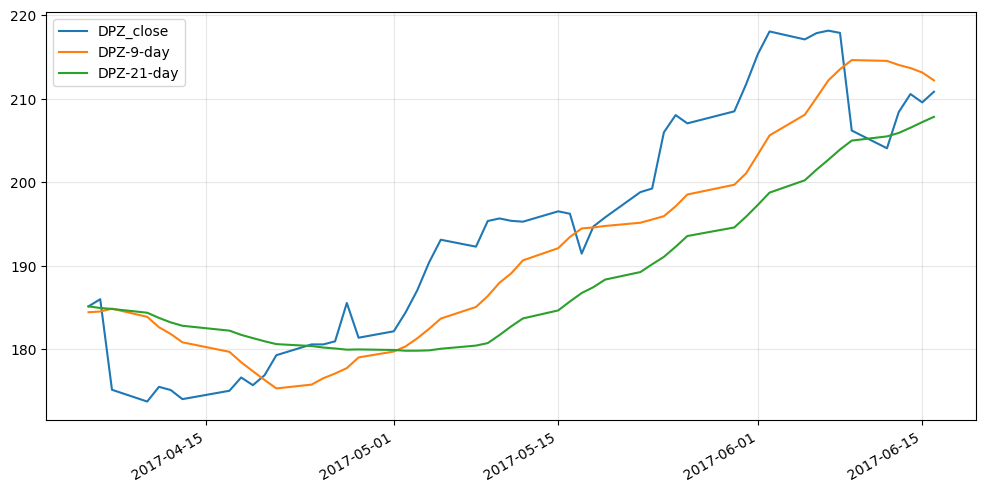

In [ ]:
# Visualized the moving averages for DPZ stock (close value, 9-day moving avg, 21-day moving avg)
# Considered first 50 days of trading

portfolio_bs.iloc[22:73,[0,3,4]].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
plt.show()

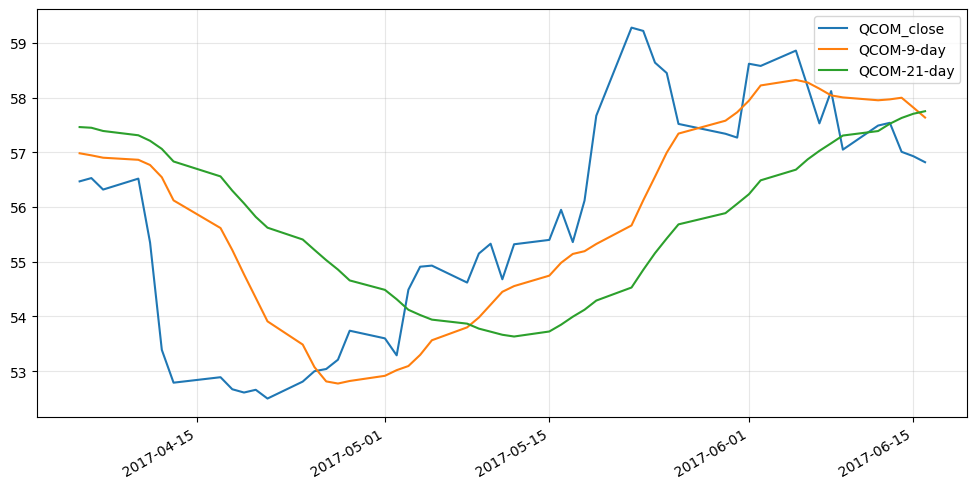

In [ ]:
# Visualized the moving averages for QCOM stock (close value, 9-day moving avg, 21-day moving avg)
# Considered first 50 days of trading

portfolio_bs.iloc[22:73,[1,5,6]].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
plt.show()

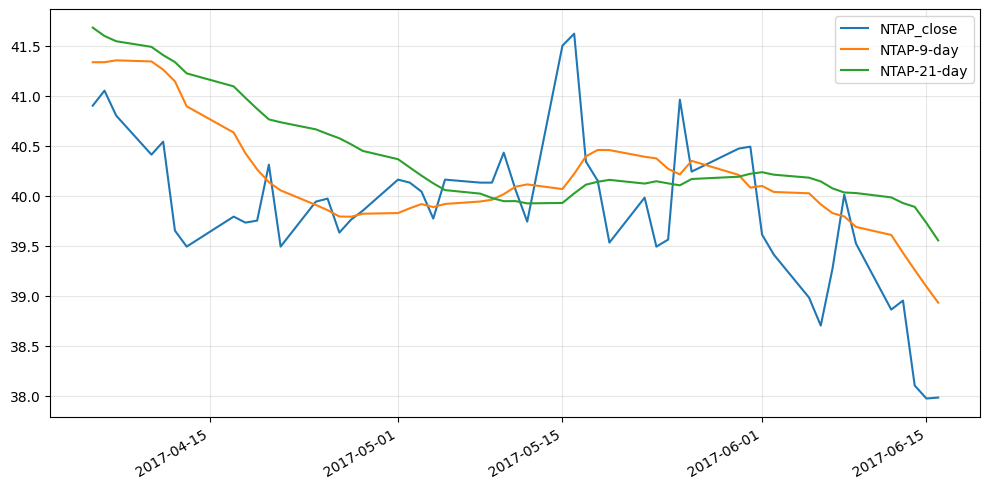

In [ ]:
# Visualized the moving averages for NTAP stock (close value, 9-day moving avg, 21-day moving avg)
# Considered first 50 days of trading

portfolio_bs.iloc[22:73,[2,7,8]].plot(figsize=(12,6))
plt.grid(True, alpha = .3)
plt.show()

In [ ]:
#### In the above 3 charts, when 9-day moving average crossovers with 21-day moving average and comes above 21-day moving average, its an indication for a bull market.
#### If 9-day moving average crossovers with 21-day moving average and comes below the 21-day moving average, its an indication for a bear market.

## 3.1 - Buy-and-Hold strategy for the MPT portfolio

##### Implementation of Buy-Hold strategy for MPT portfolio, monthwise only in the year 2022

In [ ]:
# Price will always be positive, so we can apply log transformation
portfolio_0['m_DPZ-logClose'] = np.log(portfolio_0['m_DPZ_close'])
portfolio_0['m_QCOM-logClose'] = np.log(portfolio_0['m_QCOM_close'])
portfolio_0['m_NTAP-logClose'] = np.log(portfolio_0['m_NTAP_close'])

# The difference can be positive or negative
portfolio_0['m_DPZ-return'] = portfolio_0['m_DPZ-logClose'].diff()
portfolio_0['m_QCOM-return'] = portfolio_0['m_QCOM-logClose'].diff()
portfolio_0['m_NTAP-return'] = portfolio_0['m_NTAP-logClose'].diff()
portfolio_0.head()


,m_DPZ_close,m_QCOM_close,m_NTAP_close,m_DPZ-logClose,m_QCOM-logClose,m_NTAP-logClose,m_DPZ-return,m_QCOM-return,m_NTAP-return
2022-01-01,454.649994,175.759995,86.510002,6.119528,5.169119,4.460260,NaN,NaN,NaN
2022-02-01,432.209991,171.990005,78.379997,6.068912,5.147436,4.361569,-0.050616,-0.021683,-0.098691
2022-03-01,407.010010,152.820007,83.000000,6.008838,5.029261,4.418841,-0.060074,-0.118176,0.057272
2022-04-01,338.000000,139.690002,73.250000,5.823046,4.939426,4.293878,-0.185792,-0.089835,-0.124962
2022-05-01,363.170013,143.220001,71.949997,5.894871,4.964382,4.275971,0.071825,0.024956,-0.017907


In [ ]:
# Observed the first value from the return column as NULLS, so replaced them with 0

portfolio_0.loc["2022-01-01",'m_DPZ-return'] = 0.0
portfolio_0.loc["2022-01-01",'m_QCOM-return'] = 0.0
portfolio_0.loc["2022-01-01",'m_NTAP-return'] = 0.0

In [ ]:
portfolio_0.shape

(12, 9)

In [ ]:
weight = pd.DataFrame()

In [ ]:
weight = pd.DataFrame({'m_DPZ-return': [0.265779], 'm_QCOM-return': [0.734169], 'm_NTAP-return': [0.000027]})
weight = pd.concat([weight] * 12)


In [ ]:
p_data_log = portfolio_0[['m_DPZ-return', 'm_QCOM-return', 'm_NTAP-return']]

In [ ]:
weight

,m_DPZ-return,m_QCOM-return,m_NTAP-return
0,0.265779,0.734169,0.000027
0,0.265779,0.734169,0.000027
0,0.265779,0.734169,0.000027
0,0.265779,0.734169,0.000027
0,0.265779,0.734169,0.000027
0,0.265779,0.734169,0.000027
0,0.265779,0.734169,0.000027
0,0.265779,0.734169,0.000027
0,0.265779,0.734169,0.000027
0,0.265779,0.734169,0.000027


In [ ]:
# The resulting series has the same index as the original price data and contains a single value for each month.
# These values represent the return of the portfolio for that month.
# To obtain each value in the series, we take the dot product of the row of price data with the column of optimal weights.
# This multiplication effectively multiplies each stock's return by its corresponding weight and sums the results.

pd.DataFrame(pd.Series(np.diag(p_data_log.dot(weight.transpose())), index=p_data_log.index))

,0
2022-01-01,0.000000
2022-02-01,-0.029374
2022-03-01,-0.102726
2022-04-01,-0.115337
2022-05-01,0.037411
2022-06-01,-0.065235
2022-07-01,0.094984
2022-08-01,-0.081858
2022-09-01,-0.163920
2022-10-01,0.048045


In [ ]:
# The cumulative sum indicates that the portfolio had a negative log return of 0.41 by the end of 2022.

pd.DataFrame(pd.Series(np.diag(p_data_log.dot(weight.transpose())), index=p_data_log.index).cumsum())

,0
2022-01-01,0.000000
2022-02-01,-0.029374
2022-03-01,-0.132100
2022-04-01,-0.247437
2022-05-01,-0.210026
2022-06-01,-0.275261
2022-07-01,-0.180277
2022-08-01,-0.262134
2022-09-01,-0.426055
2022-10-01,-0.378010


Result for each stock [month wise returns only for year 2022 Buy-Hold strategy]

In [ ]:
print('monthwise DPZ return from buy hold strategy is', np.exp(np.sum(portfolio_0['m_DPZ-return'])) - 1)
print('monthwise QCOM return from buy hold strategy is', np.exp(np.sum(portfolio_0['m_QCOM-return'])) - 1)
print('monthwise NTAP return from buy hold strategy is', np.exp(np.sum(portfolio_0['m_NTAP-return'])) - 1)

monthwise DPZ return from buy hold strategy is -0.23809524129158222
monthwise QCOM return from buy hold strategy is -0.37448790465722115
monthwise NTAP return from buy hold strategy is -0.3057450018471579


##### Implementation of Buy-Hold strategy, daywise between years 2017 and 2021

In [ ]:
# Price will always be positive, so we can apply log transformation
portfolio_bs['DPZ-logClose'] = np.log(portfolio_bs['DPZ_close'])
portfolio_bs['QCOM-logClose'] = np.log(portfolio_bs['QCOM_close'])
portfolio_bs['NTAP-logClose'] = np.log(portfolio_bs['NTAP_close'])

# The difference can be positive or negative
portfolio_bs['DPZ-return'] = portfolio_bs['DPZ-logClose'].diff()
portfolio_bs['QCOM-return'] = portfolio_bs['QCOM-logClose'].diff()
portfolio_bs['NTAP-return'] = portfolio_bs['NTAP-logClose'].diff()

portfolio_bs.head()


,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-logClose,QCOM-logClose,NTAP-logClose,DPZ-return,QCOM-return,NTAP-return
2017-03-06,188.889999,56.450001,42.570000,187.287776,184.924761,56.804444,55.382857,41.586667,40.212857,5.241165,4.033355,3.751150,NaN,NaN,NaN
2017-03-07,189.300003,56.730000,42.660000,187.284442,185.590475,56.771111,55.563333,41.814444,40.419048,5.243333,4.038303,3.753262,0.002168,0.004948,0.002112
2017-03-08,188.360001,57.770000,42.150002,187.984443,186.229047,56.730000,55.741905,42.032222,40.627619,5.238355,4.056470,3.741235,-0.004978,0.018166,-0.012027
2017-03-09,184.690002,57.970001,41.980000,188.213331,186.725237,56.800000,55.974762,42.166667,40.808095,5.218679,4.059926,3.737193,-0.019676,0.003456,-0.004041
2017-03-10,186.729996,58.639999,42.150002,188.036665,186.807618,56.883333,56.198571,42.281111,40.958095,5.229664,4.071417,3.741235,0.010985,0.011491,0.004041


In [ ]:
# Price will always be positive, so we can apply log transformation
portfolio_bs['DPZ-logClose'] = np.log(portfolio_bs['DPZ_close'])
portfolio_bs['QCOM-logClose'] = np.log(portfolio_bs['QCOM_close'])
portfolio_bs['NTAP-logClose'] = np.log(portfolio_bs['NTAP_close'])

# The difference can be positive or negative
portfolio_bs['DPZ-return'] = portfolio_bs['DPZ-logClose'].diff()
portfolio_bs['QCOM-return'] = portfolio_bs['QCOM-logClose'].diff()
portfolio_bs['NTAP-return'] = portfolio_bs['NTAP-logClose'].diff()

portfolio_bs.head()


,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-logClose,QCOM-logClose,NTAP-logClose,DPZ-return,QCOM-return,NTAP-return
2017-03-06,188.889999,56.450001,42.570000,187.287776,184.924761,56.804444,55.382857,41.586667,40.212857,5.241165,4.033355,3.751150,NaN,NaN,NaN
2017-03-07,189.300003,56.730000,42.660000,187.284442,185.590475,56.771111,55.563333,41.814444,40.419048,5.243333,4.038303,3.753262,0.002168,0.004948,0.002112
2017-03-08,188.360001,57.770000,42.150002,187.984443,186.229047,56.730000,55.741905,42.032222,40.627619,5.238355,4.056470,3.741235,-0.004978,0.018166,-0.012027
2017-03-09,184.690002,57.970001,41.980000,188.213331,186.725237,56.800000,55.974762,42.166667,40.808095,5.218679,4.059926,3.737193,-0.019676,0.003456,-0.004041
2017-03-10,186.729996,58.639999,42.150002,188.036665,186.807618,56.883333,56.198571,42.281111,40.958095,5.229664,4.071417,3.741235,0.010985,0.011491,0.004041


In [ ]:
# Observed the first value from the return column as NULLS, so replaced them with 0
portfolio_bs.loc["2017-02-02", 'DPZ-return'] = 0.0
portfolio_bs.loc["2017-02-02", 'QCOM-return'] = 0.0
portfolio_bs.loc["2017-02-02", 'NTAP-return'] = 0.0


In [ ]:
portfolio_bs.tail()

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-logClose,QCOM-logClose,NTAP-logClose,DPZ-return,QCOM-return,NTAP-return
2021-12-27,557.210022,186.330002,93.339996,531.805562,529.524288,181.100001,180.369525,88.544444,89.161904,6.322942,5.227519,4.536249,0.020616,0.019455,0.029463
2021-12-28,557.770020,184.820007,93.260002,534.011122,530.630480,181.434445,180.637144,89.227776,89.331427,6.323947,5.219382,4.535391,0.001004,-0.008137,-0.000857
2021-12-29,562.400024,186.199997,93.180000,537.857788,531.958576,181.750002,181.069525,89.941110,89.566666,6.332213,5.226821,4.534533,0.008267,0.007439,-0.000858
2021-12-30,557.409973,182.729996,91.690002,542.133348,533.313339,181.407779,181.186667,90.438889,89.645713,6.323301,5.208010,4.518413,-0.008912,-0.018812,-0.016120
2017-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000


Result Buy-Hold strategy, daywise between years 2017 and 2021

In [ ]:
print('DPZ return from buy hold strategy is', np.exp(np.sum(portfolio_bs['DPZ-return'])) - 1)
print('QCOM return from buy hold strategy is', np.exp(np.sum(portfolio_bs['QCOM-return'])) - 1)
print('NTAP return from buy hold strategy is', np.exp(np.sum(portfolio_bs['NTAP-return'])) - 1)

DPZ return from buy hold strategy is 1.9509766263204202
QCOM return from buy hold strategy is 2.2370237955338506
NTAP return from buy hold strategy is 1.1538642964226797


## 3.2 - Momentum trading strategy for each stock in the MPT portfolio

### 3.2.0 - Data Preparation for implementing 8-21 momentum trading strategy

In [ ]:
portfolio

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day
2017-01-03,158.360001,65.400002,35.570000,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,162.990005,65.470001,35.650002,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,162.770004,65.550003,35.360001,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,163.490005,65.529999,35.230000,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,164.509995,65.650002,35.230000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-12-23,545.840027,182.740005,90.629997,531.805562,529.524288,181.100001,180.369525,88.544444,89.161904
2021-12-27,557.210022,186.330002,93.339996,534.011122,530.630480,181.434445,180.637144,89.227776,89.331427
2021-12-28,557.770020,184.820007,93.260002,537.857788,531.958576,181.750002,181.069525,89.941110,89.566666
2021-12-29,562.400024,186.199997,93.180000,542.133348,533.313339,181.407779,181.186667,90.438889,89.645713


In [ ]:
portfolio['DPZ-8-day'] = portfolio['DPZ_close'].rolling(8).mean()
portfolio['QCOM-8-day'] = portfolio['QCOM_close'].rolling(8).mean()
portfolio['NTAP-8-day'] = portfolio['NTAP_close'].rolling(8).mean()


In [ ]:
portfolio.head(25)

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day
2017-01-03,158.360001,65.400002,35.570000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,162.990005,65.470001,35.650002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,162.770004,65.550003,35.360001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,163.490005,65.529999,35.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,164.509995,65.650002,35.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,166.360001,65.629997,35.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,168.960007,66.099998,35.650002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-12,168.360001,66.120003,35.810001,NaN,NaN,NaN,NaN,NaN,NaN,164.475002,65.681251,35.468750
2017-01-13,167.160004,66.879997,35.930000,164.773336,NaN,65.814445,NaN,35.520000,NaN,165.575003,65.866250,35.513751
2017-01-17,164.929993,64.190002,35.560001,165.503335,NaN,65.680000,NaN,35.518890,NaN,165.817501,65.706250,35.502501


In [ ]:
# Created a copy of our main dataframe so that the main dataframe is preserved and calculations related to Buy-Hold strategy are done on copied version

portfolio_bs1 = portfolio.copy()

In [ ]:
portfolio_bs1.head(25)

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day
2017-01-03,158.360001,65.400002,35.570000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,162.990005,65.470001,35.650002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,162.770004,65.550003,35.360001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,163.490005,65.529999,35.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,164.509995,65.650002,35.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,166.360001,65.629997,35.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,168.960007,66.099998,35.650002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-12,168.360001,66.120003,35.810001,NaN,NaN,NaN,NaN,NaN,NaN,164.475002,65.681251,35.468750
2017-01-13,167.160004,66.879997,35.930000,164.773336,NaN,65.814445,NaN,35.520000,NaN,165.575003,65.866250,35.513751
2017-01-17,164.929993,64.190002,35.560001,165.503335,NaN,65.680000,NaN,35.518890,NaN,165.817501,65.706250,35.502501


In [ ]:
portfolio_bs1['DPZ-8-day'] = portfolio_bs1['DPZ_close'].rolling(8).mean().shift()
portfolio_bs1['QCOM-8-day'] = portfolio_bs1['QCOM_close'].rolling(8).mean().shift()
portfolio_bs1['NTAP-8-day'] = portfolio_bs1['NTAP_close'].rolling(8).mean().shift()
portfolio_bs1['DPZ-21-day'] = portfolio_bs1['DPZ_close'].rolling(21).mean().shift()
portfolio_bs1['QCOM-21-day'] = portfolio_bs1['QCOM_close'].rolling(21).mean().shift()
portfolio_bs1['NTAP-21-day'] = portfolio_bs1['NTAP_close'].rolling(21).mean().shift()


In [ ]:
# Dropped the NULL values which showed up due to the moving average calculations

portfolio_bs1.dropna(inplace=True)
portfolio_bs1.tail()

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day
2021-12-23,545.840027,182.740005,90.629997,531.805562,528.860952,181.100001,180.283811,88.544444,88.977618,530.051254,180.895000,88.283750
2021-12-27,557.210022,186.330002,93.339996,534.011122,529.524288,181.434445,180.369525,89.227776,89.161904,531.111259,180.822500,88.713749
2021-12-28,557.770020,184.820007,93.260002,537.857788,530.630480,181.750002,180.637144,89.941110,89.331427,535.368759,181.366251,89.526249
2021-12-29,562.400024,186.199997,93.180000,542.133348,531.958576,181.407779,181.069525,90.438889,89.566666,539.600014,180.808752,90.096250
2021-12-30,557.409973,182.729996,91.690002,544.934455,533.313339,181.916668,181.186667,90.832222,89.645713,543.375015,181.815002,90.724999


In [ ]:
portfolio_bs1.shape

(1237, 12)

### 3.2.1 - Implementing 8-21 momentum trading strategy

In [ ]:
# Apply log transformation on the closing value of the stocks
portfolio_bs1['DPZ-logClose'] = np.log(portfolio_bs1['DPZ_close'])
portfolio_bs1['QCOM-logClose'] = np.log(portfolio_bs1['QCOM_close'])
portfolio_bs1['NTAP-logClose'] = np.log(portfolio_bs1['NTAP_close'])

# Calculate the returns on the closing values of the stocks
portfolio_bs1['DPZ-return'] = portfolio_bs1['DPZ-logClose'].diff()
portfolio_bs1['QCOM-return'] = portfolio_bs1['QCOM-logClose'].diff()
portfolio_bs1['NTAP-return'] = portfolio_bs1['NTAP-logClose'].diff()

portfolio_bs1.head()


,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day,DPZ-logClose,QCOM-logClose,NTAP-logClose,DPZ-return,QCOM-return,NTAP-return
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,54.407501,37.679999,5.164272,3.963856,3.643882,NaN,NaN,NaN
2017-02-03,175.889999,52.980000,38.279999,172.577777,168.255238,54.002223,60.547143,37.976666,36.549524,172.163750,54.130001,37.938750,5.169859,3.969914,3.644928,0.005587,0.006058,0.001045
2017-02-06,177.940002,52.880001,38.360001,173.514445,168.869524,53.766667,59.952381,38.070000,36.674762,172.961250,53.877501,38.033750,5.181446,3.968025,3.647015,0.011588,-0.001889,0.002088
2017-02-07,182.960007,53.270000,38.830002,174.891112,169.591904,53.363334,59.349048,38.167778,36.817619,173.882500,53.375000,38.085000,5.209268,3.975373,3.659193,0.027821,0.007348,0.012178
2017-02-08,185.179993,52.889999,38.959999,176.473333,170.519047,53.234445,58.765238,38.318889,36.989048,175.385000,53.277501,38.238750,5.221328,3.968214,3.662535,0.012061,-0.007159,0.003342


In [ ]:
# Observed the first value from the return column as NULLS, replaced them with 0
portfolio_bs1.loc["2017-02-02",'DPZ-return'] = 0.0
portfolio_bs1.loc["2017-02-02",'QCOM-return'] = 0.0
portfolio_bs1.loc["2017-02-02",'NTAP-return'] = 0.0

In [ ]:
portfolio_bs1.head()

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day,DPZ-logClose,QCOM-logClose,NTAP-logClose,DPZ-return,QCOM-return,NTAP-return
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,54.407501,37.679999,5.164272,3.963856,3.643882,0.000000,0.000000,0.000000
2017-02-03,175.889999,52.980000,38.279999,172.577777,168.255238,54.002223,60.547143,37.976666,36.549524,172.163750,54.130001,37.938750,5.169859,3.969914,3.644928,0.005587,0.006058,0.001045
2017-02-06,177.940002,52.880001,38.360001,173.514445,168.869524,53.766667,59.952381,38.070000,36.674762,172.961250,53.877501,38.033750,5.181446,3.968025,3.647015,0.011588,-0.001889,0.002088
2017-02-07,182.960007,53.270000,38.830002,174.891112,169.591904,53.363334,59.349048,38.167778,36.817619,173.882500,53.375000,38.085000,5.209268,3.975373,3.659193,0.027821,0.007348,0.012178
2017-02-08,185.179993,52.889999,38.959999,176.473333,170.519047,53.234445,58.765238,38.318889,36.989048,175.385000,53.277501,38.238750,5.221328,3.968214,3.662535,0.012061,-0.007159,0.003342


In [ ]:
# The purpose of this column is to show whether we are currently investing money or if we are out of the market.
# Invested = 1 if the 8-day average is greater than the 21-day average, else 0
portfolio_bs1['DPZ-invested'] = np.where(portfolio_bs1['DPZ-8-day'] > portfolio_bs1['DPZ-21-day'], 1, 0)
portfolio_bs1['QCOM-invested'] = np.where(portfolio_bs1['QCOM-8-day'] > portfolio_bs1['QCOM-21-day'], 1, 0)
portfolio_bs1['NTAP-invested'] = np.where(portfolio_bs1['NTAP-8-day'] > portfolio_bs1['NTAP-21-day'], 1, 0)

In [ ]:
portfolio_bs1.head()


,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,...,NTAP-8-day,DPZ-logClose,QCOM-logClose,NTAP-logClose,DPZ-return,QCOM-return,NTAP-return,DPZ-invested,QCOM-invested,NTAP-invested
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,...,37.679999,5.164272,3.963856,3.643882,0.000000,0.000000,0.000000,1,0,1
2017-02-03,175.889999,52.980000,38.279999,172.577777,168.255238,54.002223,60.547143,37.976666,36.549524,172.163750,...,37.938750,5.169859,3.969914,3.644928,0.005587,0.006058,0.001045,1,0,1
2017-02-06,177.940002,52.880001,38.360001,173.514445,168.869524,53.766667,59.952381,38.070000,36.674762,172.961250,...,38.033750,5.181446,3.968025,3.647015,0.011588,-0.001889,0.002088,1,0,1
2017-02-07,182.960007,53.270000,38.830002,174.891112,169.591904,53.363334,59.349048,38.167778,36.817619,173.882500,...,38.085000,5.209268,3.975373,3.659193,0.027821,0.007348,0.012178,1,0,1
2017-02-08,185.179993,52.889999,38.959999,176.473333,170.519047,53.234445,58.765238,38.318889,36.989048,175.385000,...,38.238750,5.221328,3.968214,3.662535,0.012061,-0.007159,0.003342,1,0,1


In [ ]:
print(portfolio_bs1['DPZ-invested'].value_counts())

1    740
0    497
Name: DPZ-invested, dtype: int64


In [ ]:
print(portfolio_bs1['QCOM-invested'].value_counts())

1    714
0    523
Name: QCOM-invested, dtype: int64


In [ ]:
print(portfolio_bs1['NTAP-invested'].value_counts())

1    759
0    478
Name: NTAP-invested, dtype: int64


In [ ]:
# Created a column called 'signal' which indicates when we enter and leave the market based on the Momentum Trading Strategy.
# We are buying/selling at the transition points, when the plots are intersecting and the trend is changing.
# A value of +1 indicates buying, and a value of -1 indicates selling. This happens when the trend flips.
portfolio_bs1['DPZ-signal'] = portfolio_bs1['DPZ-invested'].diff()
portfolio_bs1['QCOM-signal'] = portfolio_bs1['QCOM-invested'].diff()
portfolio_bs1['NTAP-signal'] = portfolio_bs1['NTAP-invested'].diff()

In [ ]:
print(portfolio_bs1['DPZ-signal'].value_counts())

 0.0    1174
-1.0      31
 1.0      31
Name: DPZ-signal, dtype: int64


In [ ]:
print(portfolio_bs1['QCOM-signal'].value_counts())


 0.0    1177
 1.0      30
-1.0      29
Name: QCOM-signal, dtype: int64


In [ ]:
print(portfolio_bs1['NTAP-signal'].value_counts())

 0.0    1168
-1.0      34
 1.0      34
Name: NTAP-signal, dtype: int64


In [ ]:
# Set the signal to 1 on the initial day when there is NULL value, which means, we are buying stocks on the first trading day:

portfolio_bs1.loc["2017-02-02",'DPZ-signal'] = 1.0
portfolio_bs1.loc["2017-02-02",'QCOM-signal'] = 1.0
portfolio_bs1.loc["2017-02-02",'NTAP-signal'] = 1.0

In [ ]:
portfolio_bs1.head()

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,...,NTAP-logClose,DPZ-return,QCOM-return,NTAP-return,DPZ-invested,QCOM-invested,NTAP-invested,DPZ-signal,QCOM-signal,NTAP-signal
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,...,3.643882,0.000000,0.000000,0.000000,1,0,1,1.0,1.0,1.0
2017-02-03,175.889999,52.980000,38.279999,172.577777,168.255238,54.002223,60.547143,37.976666,36.549524,172.163750,...,3.644928,0.005587,0.006058,0.001045,1,0,1,0.0,0.0,0.0
2017-02-06,177.940002,52.880001,38.360001,173.514445,168.869524,53.766667,59.952381,38.070000,36.674762,172.961250,...,3.647015,0.011588,-0.001889,0.002088,1,0,1,0.0,0.0,0.0
2017-02-07,182.960007,53.270000,38.830002,174.891112,169.591904,53.363334,59.349048,38.167778,36.817619,173.882500,...,3.659193,0.027821,0.007348,0.012178,1,0,1,0.0,0.0,0.0
2017-02-08,185.179993,52.889999,38.959999,176.473333,170.519047,53.234445,58.765238,38.318889,36.989048,175.385000,...,3.662535,0.012061,-0.007159,0.003342,1,0,1,0.0,0.0,0.0


In [ ]:
# Retrieved only those days when trading was done for DPZ stock

portfolio_bs1[portfolio_bs1['DPZ-signal'].isin([1,-1])]

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,...,NTAP-logClose,DPZ-return,QCOM-return,NTAP-return,DPZ-invested,QCOM-invested,NTAP-invested,DPZ-signal,QCOM-signal,NTAP-signal
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,...,3.643882,0.000000,0.000000,0.000000,1,0,1,1.0,1.0,1.0
2017-03-16,185.619995,58.349998,42.200001,186.702221,186.912856,57.901111,57.110000,42.216667,41.486191,186.837500,...,3.742420,-0.003496,-0.002909,-0.000474,0,1,1,-1.0,0.0,0.0
2017-04-07,175.160004,56.320000,40.799999,183.890001,184.835239,56.864445,57.390953,41.342222,41.544286,184.981251,...,3.708682,-0.060047,-0.003722,-0.006109,1,0,0,1.0,0.0,0.0
2017-04-10,173.750000,56.520000,40.410000,182.646667,184.381429,56.768889,57.312381,41.260000,41.488096,183.758751,...,3.699077,-0.008082,0.003545,-0.009605,0,0,0,-1.0,0.0,0.0
2017-05-01,182.160004,53.599998,40.160000,180.351113,179.923810,53.018889,54.486667,39.873333,40.364286,180.125002,...,3.692871,0.004236,-0.002609,0.007749,1,0,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-09,516.119995,141.580002,92.089996,516.078891,515.456191,144.614446,144.788571,89.598888,84.607142,516.073753,...,4.522766,-0.010121,-0.006617,0.028304,1,1,1,1.0,1.0,0.0
2021-09-15,505.559998,138.240005,93.300003,513.087775,514.374762,142.563334,143.858572,91.363333,86.403809,514.028748,...,4.535820,-0.002765,-0.020761,0.011968,0,0,1,-1.0,0.0,0.0
2021-11-02,486.869995,135.229996,90.260002,476.347772,473.501426,132.945553,129.738570,90.808890,90.975238,475.032494,...,4.502694,-0.001047,0.003111,0.001552,1,1,0,1.0,0.0,0.0
2021-12-13,537.359985,183.320007,87.190002,527.685550,526.940950,180.047779,178.797143,89.354444,89.002380,526.476246,...,4.468090,0.005486,-0.003050,-0.024136,0,1,1,-1.0,0.0,0.0


In [ ]:
# Retrieved only those days when trading was done for QCOM stock

portfolio_bs1[portfolio_bs1['QCOM-signal'].isin([1,-1])]

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,...,NTAP-logClose,DPZ-return,QCOM-return,NTAP-return,DPZ-invested,QCOM-invested,NTAP-invested,DPZ-signal,QCOM-signal,NTAP-signal
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,...,3.643882,0.000000,0.000000,0.000000,1,0,1,1.0,1.0,1.0
2017-02-21,188.919998,56.750000,40.520000,186.116665,177.863809,55.195556,54.759048,39.666667,38.476190,185.766249,...,3.701796,0.005254,0.005123,0.008675,1,1,1,0.0,1.0,0.0
2017-03-28,184.940002,57.380001,41.150002,184.275557,186.158571,57.257778,57.320476,41.325556,41.890477,184.192501,...,3.717224,0.005367,0.012627,0.006094,0,0,0,0.0,-1.0,0.0
2017-05-08,192.289993,54.619999,40.130001,186.371112,180.448096,53.981111,53.869048,39.958889,40.020000,185.631252,...,3.692124,-0.004307,-0.005660,-0.000747,1,1,0,0.0,1.0,0.0
2017-06-16,210.839996,56.820000,37.980000,211.500000,207.831430,57.410000,57.752381,38.817778,39.551905,211.582500,...,3.637060,0.006089,-0.001934,0.000263,1,0,0,0.0,-1.0,0.0
2017-07-19,212.520004,56.779999,44.160000,211.274445,212.649047,56.121111,56.002858,41.446666,40.054285,211.118750,...,3.787819,0.005048,0.008667,0.008871,0,1,1,0.0,1.0,0.0
2017-07-25,192.399994,53.270000,44.759998,209.323334,212.040001,55.207778,55.555715,43.949999,41.196190,211.438751,...,3.801315,-0.106259,0.000939,-0.002232,0,0,1,0.0,-1.0,0.0
2017-09-21,198.039993,52.029999,41.860001,193.249998,186.511427,51.634444,51.540000,40.804445,39.340476,192.651249,...,3.734331,0.002325,0.000961,0.003830,1,1,1,0.0,1.0,0.0
2017-12-07,179.509995,65.230003,57.529999,181.173331,177.405239,66.036666,66.141428,56.554444,52.373809,181.381248,...,4.052307,-0.009205,0.003840,0.005578,1,0,1,0.0,-1.0,0.0
2018-01-05,200.300003,66.470001,58.849998,192.104445,186.354285,65.067778,64.835714,56.525556,56.986190,191.080000,...,4.074992,0.015142,0.006642,0.017830,1,1,0,0.0,1.0,0.0


In [ ]:
# Retrieved only those days when trading was done for NTAP stock

portfolio_bs1[portfolio_bs1['NTAP-signal'].isin([1,-1])]

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,...,NTAP-logClose,DPZ-return,QCOM-return,NTAP-return,DPZ-invested,QCOM-invested,NTAP-invested,DPZ-signal,QCOM-signal,NTAP-signal
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,...,3.643882,0.000000,0.000000,0.000000,1,0,1,1.0,1.0,1.0
2017-03-23,184.350006,56.810001,40.900002,184.818890,186.364761,57.728889,57.371428,41.693334,41.886191,184.877501,...,3.711130,0.001194,-0.004040,-0.001954,0,1,0,0.0,0.0,-1.0
2017-05-09,195.360001,55.150002,40.130001,187.971112,180.747620,54.215556,53.778095,40.014445,39.976191,187.047501,...,3.692124,0.015839,0.009657,0.000000,1,1,1,0.0,0.0,1.0
2017-05-30,208.490005,57.340000,40.470001,201.065559,194.589049,57.733333,55.889048,40.080001,40.189048,200.137503,...,3.700561,0.006931,-0.003134,0.005699,1,1,0,0.0,0.0,-1.0
2017-06-29,210.750000,55.080002,40.099998,215.373333,213.967619,56.371112,57.251429,39.411111,39.164286,215.951250,...,3.691376,-0.013433,-0.019418,-0.007701,1,0,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-15,517.320007,168.509995,88.860001,502.045556,482.237139,160.875556,142.898095,90.826667,91.053809,500.136250,...,4.487062,0.007801,0.021413,-0.010412,1,1,1,0.0,0.0,1.0
2021-11-17,531.479980,183.539993,87.959999,508.944441,488.320949,168.737778,147.183809,90.382222,90.712857,506.127499,...,4.476882,0.011791,0.009470,-0.008829,1,1,0,0.0,0.0,-1.0
2021-12-07,537.429993,183.720001,90.669998,526.097782,519.792382,178.787779,175.127143,89.673332,89.338095,524.681255,...,4.507227,0.038601,0.046059,0.027620,1,1,1,0.0,0.0,1.0
2021-12-20,530.609985,176.669998,87.529999,530.499993,529.355238,181.663333,181.002382,88.323332,88.605237,530.486244,...,4.471982,0.004212,-0.000736,-0.006037,1,1,0,0.0,0.0,-1.0


In [ ]:
# Checked how much money was made or lost using this strategy for each stock
portfolio_bs1['DPZ-system_return'] = portfolio_bs1['DPZ-invested'] * portfolio_bs1['DPZ-return']
portfolio_bs1['QCOM-system_return'] = portfolio_bs1['QCOM-invested'] * portfolio_bs1['QCOM-return']
portfolio_bs1['NTAP-system_return'] = portfolio_bs1['NTAP-invested'] * portfolio_bs1['NTAP-return']



In [ ]:
portfolio_bs1.head()

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,...,NTAP-return,DPZ-invested,QCOM-invested,NTAP-invested,DPZ-signal,QCOM-signal,NTAP-signal,DPZ-system_return,QCOM-system_return,NTAP-system_return
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,...,0.000000,1,0,1,1.0,1.0,1.0,0.000000,0.0,0.000000
2017-02-03,175.889999,52.980000,38.279999,172.577777,168.255238,54.002223,60.547143,37.976666,36.549524,172.163750,...,0.001045,1,0,1,0.0,0.0,0.0,0.005587,0.0,0.001045
2017-02-06,177.940002,52.880001,38.360001,173.514445,168.869524,53.766667,59.952381,38.070000,36.674762,172.961250,...,0.002088,1,0,1,0.0,0.0,0.0,0.011588,-0.0,0.002088
2017-02-07,182.960007,53.270000,38.830002,174.891112,169.591904,53.363334,59.349048,38.167778,36.817619,173.882500,...,0.012178,1,0,1,0.0,0.0,0.0,0.027821,0.0,0.012178
2017-02-08,185.179993,52.889999,38.959999,176.473333,170.519047,53.234445,58.765238,38.318889,36.989048,175.385000,...,0.003342,1,0,1,0.0,0.0,0.0,0.012061,-0.0,0.003342


In [ ]:
# Calculated returns using this 8-21 Momentum trading strategy for each stock
print('Returns from 8-21 momentum trading strategy for DPZ stock is', np.exp(np.sum(portfolio_bs1['DPZ-system_return'])) - 1)
print('Returns from 8-21 momentum trading strategy for QCOM stock is', np.exp(np.sum(portfolio_bs1['QCOM-system_return'])) - 1)
print('Returns from 8-21 momentum trading strategy for NTAP stock is', np.exp(np.sum(portfolio_bs1['NTAP-system_return'])) - 1)

Returns from 8-21 momentum trading strategy for DPZ stock is 1.1878618505680336
Returns from 8-21 momentum trading strategy for QCOM stock is 2.1222977032682255
Returns from 8-21 momentum trading strategy for NTAP stock is 0.9220788302549192


In [ ]:
portfolio_bs1.columns

Index(['DPZ_close', 'QCOM_close', 'NTAP_close', 'DPZ-9-day', 'DPZ-21-day',
       'QCOM-9-day', 'QCOM-21-day', 'NTAP-9-day', 'NTAP-21-day', 'DPZ-8-day',
       'QCOM-8-day', 'NTAP-8-day', 'DPZ-logClose', 'QCOM-logClose',
       'NTAP-logClose', 'DPZ-return', 'QCOM-return', 'NTAP-return',
       'DPZ-invested', 'QCOM-invested', 'NTAP-invested', 'DPZ-signal',
       'QCOM-signal', 'NTAP-signal', 'DPZ-system_return', 'QCOM-system_return',
       'NTAP-system_return'],
      dtype='object')

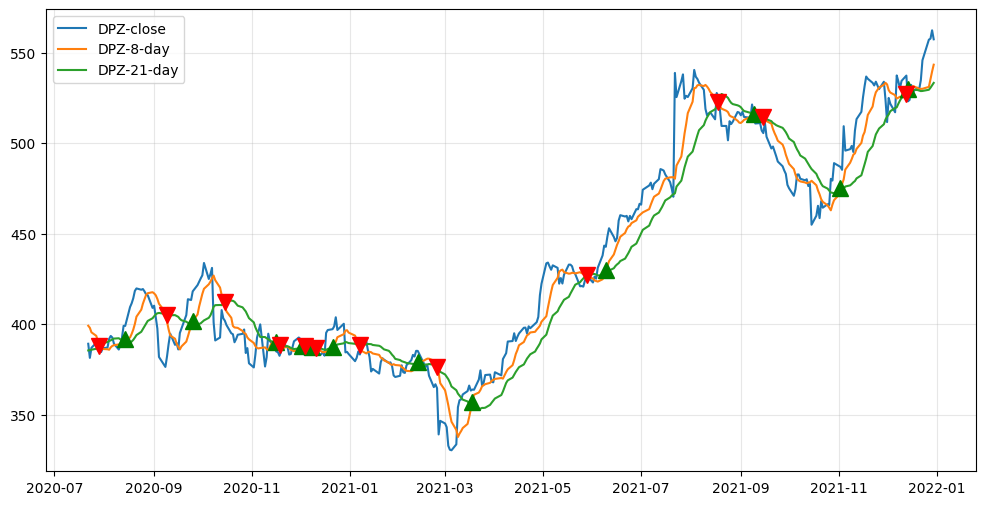

In [ ]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(portfolio_bs1.iloc[-365:]['DPZ_close'], label = 'DPZ-close') # actual value
plt.plot(portfolio_bs1.iloc[-365:]['DPZ-8-day'], label = 'DPZ-8-day') # 8-day average
plt.plot(portfolio_bs1.iloc[-365:]['DPZ-21-day'], label = 'DPZ-21-day') # 21-day average
plt.plot(portfolio_bs1[-365:].loc[portfolio_bs1['DPZ-signal'] == 1].index, portfolio_bs1[-365:]['DPZ-8-day'][portfolio_bs1['DPZ-signal'] == 1], '^',
         color = 'g', markersize = 12)
plt.plot(portfolio_bs1[-365:].loc[portfolio_bs1['DPZ-signal'] == -1].index, portfolio_bs1[-365:]['DPZ-21-day'][portfolio_bs1['DPZ-signal'] == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);


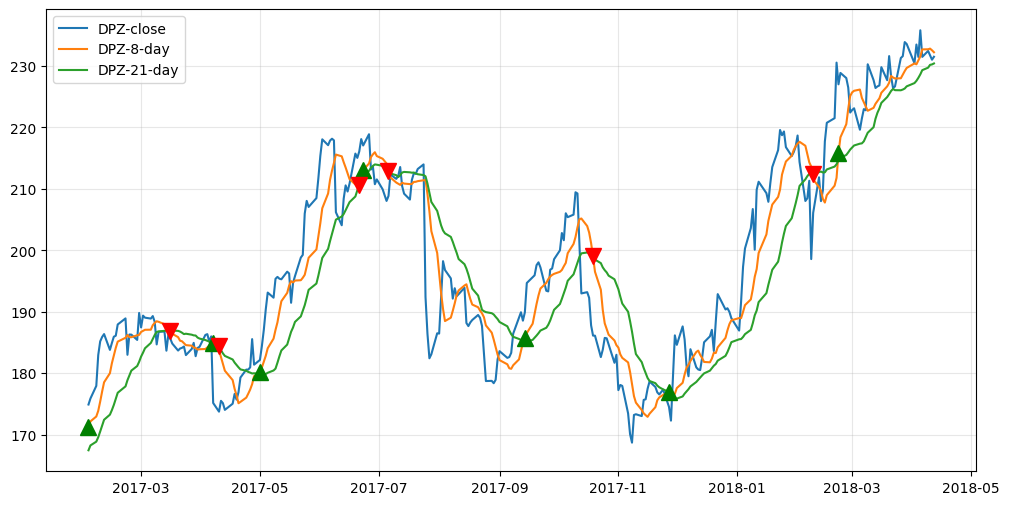

In [ ]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(portfolio_bs1.iloc[:300]['DPZ_close'], label = 'DPZ-close') # actual value
plt.plot(portfolio_bs1.iloc[:300]['DPZ-8-day'], label = 'DPZ-8-day') # 8-day average
plt.plot(portfolio_bs1.iloc[:300]['DPZ-21-day'], label = 'DPZ-21-day') # 21-day average
plt.plot(portfolio_bs1[:300].loc[portfolio_bs1['DPZ-signal'] == 1].index, portfolio_bs1[:300]['DPZ-8-day'][portfolio_bs1['DPZ-signal'] == 1], '^',
         color = 'g', markersize = 12)
plt.plot(portfolio_bs1[:300].loc[portfolio_bs1['DPZ-signal'] == -1].index, portfolio_bs1[:300]['DPZ-21-day'][portfolio_bs1['DPZ-signal'] == -1], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);


## 3.3 - Momentum trading strategy for the entire MPT portfolio

##3.3.0 - Preparation steps before implementing Momentum trading strategy

In [ ]:
portfolio.head()

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day
2017-01-03,158.360001,65.400002,35.570000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,162.990005,65.470001,35.650002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,162.770004,65.550003,35.360001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,163.490005,65.529999,35.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,164.509995,65.650002,35.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Created a copy of our main dataframe so that the main dataframe is preserved and calculations related to Buy-Hold strategy is done on copied version

portfolio_bs2 = portfolio.copy()

In [ ]:
portfolio_bs2.head()

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day
2017-01-03,158.360001,65.400002,35.570000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,162.990005,65.470001,35.650002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,162.770004,65.550003,35.360001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,163.490005,65.529999,35.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,164.509995,65.650002,35.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Calculated the 8-day and 21-day average

portfolio_bs2['DPZ-8-day'] = portfolio_bs2['DPZ_close'].rolling(8).mean().shift()
portfolio_bs2['QCOM-8-day'] = portfolio_bs2['QCOM_close'].rolling(8).mean().shift()
portfolio_bs2['NTAP-8-day'] = portfolio_bs2['NTAP_close'].rolling(8).mean().shift()
portfolio_bs2['DPZ-21-day'] = portfolio_bs2['DPZ_close'].rolling(21).mean().shift()
portfolio_bs2['QCOM-21-day'] = portfolio_bs2['QCOM_close'].rolling(21).mean().shift()
portfolio_bs2['NTAP-21-day'] = portfolio_bs2['NTAP_close'].rolling(21).mean().shift()


In [ ]:
# Dropped the NULL values that showed up due to the above moving average calculations

portfolio_bs2.dropna(inplace=True)
portfolio_bs2.head()

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,54.407501,37.679999
2017-02-03,175.889999,52.980000,38.279999,172.577777,168.255238,54.002223,60.547143,37.976666,36.549524,172.163750,54.130001,37.938750
2017-02-06,177.940002,52.880001,38.360001,173.514445,168.869524,53.766667,59.952381,38.070000,36.674762,172.961250,53.877501,38.033750
2017-02-07,182.960007,53.270000,38.830002,174.891112,169.591904,53.363334,59.349048,38.167778,36.817619,173.882500,53.375000,38.085000
2017-02-08,185.179993,52.889999,38.959999,176.473333,170.519047,53.234445,58.765238,38.318889,36.989048,175.385000,53.277501,38.238750


In [ ]:
portfolio_bs2.shape


(1237, 12)

##3.3.1 - Implementing the 8-21 Momentum trading strategy for the entire MPT portfolio

In [ ]:
# Price will always be positive, so we can apply log transformation on the closing value of the stock
portfolio_bs2['DPZ-logClose'] = np.log(portfolio_bs2['DPZ_close'])

# The difference can be positive or negative
portfolio_bs2['DPZ-return'] = portfolio_bs2['DPZ-logClose'].diff()

portfolio_bs2['QCOM-logClose'] = np.log(portfolio_bs2['QCOM_close'])
portfolio_bs2['QCOM-return'] = portfolio_bs2['QCOM-logClose'].diff()

portfolio_bs2['NTAP-logClose'] = np.log(portfolio_bs2['NTAP_close'])
portfolio_bs2['NTAP-return'] = portfolio_bs2['NTAP-logClose'].diff()

portfolio_bs2.head()


,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day,DPZ-logClose,DPZ-return,QCOM-logClose,QCOM-return,NTAP-logClose,NTAP-return
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,54.407501,37.679999,5.164272,NaN,3.963856,NaN,3.643882,NaN
2017-02-03,175.889999,52.980000,38.279999,172.577777,168.255238,54.002223,60.547143,37.976666,36.549524,172.163750,54.130001,37.938750,5.169859,0.005587,3.969914,0.006058,3.644928,0.001045
2017-02-06,177.940002,52.880001,38.360001,173.514445,168.869524,53.766667,59.952381,38.070000,36.674762,172.961250,53.877501,38.033750,5.181446,0.011588,3.968025,-0.001889,3.647015,0.002088
2017-02-07,182.960007,53.270000,38.830002,174.891112,169.591904,53.363334,59.349048,38.167778,36.817619,173.882500,53.375000,38.085000,5.209268,0.027821,3.975373,0.007348,3.659193,0.012178
2017-02-08,185.179993,52.889999,38.959999,176.473333,170.519047,53.234445,58.765238,38.318889,36.989048,175.385000,53.277501,38.238750,5.221328,0.012061,3.968214,-0.007159,3.662535,0.003342


In [ ]:
# Observed the first value from the return column as NULLS, replaced them with 0
portfolio_bs2.loc["2017-02-02", 'DPZ-return'] = 0.0
portfolio_bs2.loc["2017-02-02", 'QCOM-return'] = 0.0
portfolio_bs2.loc["2017-02-02", 'NTAP-return'] = 0.0

In [ ]:
portfolio_bs2.head()


,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day,DPZ-logClose,DPZ-return,QCOM-logClose,QCOM-return,NTAP-logClose,NTAP-return
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,54.407501,37.679999,5.164272,0.000000,3.963856,0.000000,3.643882,0.000000
2017-02-03,175.889999,52.980000,38.279999,172.577777,168.255238,54.002223,60.547143,37.976666,36.549524,172.163750,54.130001,37.938750,5.169859,0.005587,3.969914,0.006058,3.644928,0.001045
2017-02-06,177.940002,52.880001,38.360001,173.514445,168.869524,53.766667,59.952381,38.070000,36.674762,172.961250,53.877501,38.033750,5.181446,0.011588,3.968025,-0.001889,3.647015,0.002088
2017-02-07,182.960007,53.270000,38.830002,174.891112,169.591904,53.363334,59.349048,38.167778,36.817619,173.882500,53.375000,38.085000,5.209268,0.027821,3.975373,0.007348,3.659193,0.012178
2017-02-08,185.179993,52.889999,38.959999,176.473333,170.519047,53.234445,58.765238,38.318889,36.989048,175.385000,53.277501,38.238750,5.221328,0.012061,3.968214,-0.007159,3.662535,0.003342


In [ ]:
# "Tot-invested" is to show whether we are currently investing money or if we are out of the market.
# Invested = 1 if the 8-day average is greater than the 21-day average for all the stocks together, else 0
# But in this strategy, either we buy all stocks together or hold all together or sell them all together. So, I have to maintain a common condition based on which invested column is decided.
portfolio_bs2['tot-invested'] = np.where((portfolio_bs2['DPZ-8-day'] > portfolio_bs2['DPZ-21-day']) & (portfolio_bs2['QCOM-8-day'] > portfolio_bs2['QCOM-21-day']) & (portfolio_bs2['NTAP-8-day'] > portfolio_bs2['NTAP-21-day']), 1, 0)


In [ ]:
portfolio_bs2.head()

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day,DPZ-logClose,DPZ-return,QCOM-logClose,QCOM-return,NTAP-logClose,NTAP-return,tot-invested
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,54.407501,37.679999,5.164272,0.000000,3.963856,0.000000,3.643882,0.000000,0
2017-02-03,175.889999,52.980000,38.279999,172.577777,168.255238,54.002223,60.547143,37.976666,36.549524,172.163750,54.130001,37.938750,5.169859,0.005587,3.969914,0.006058,3.644928,0.001045,0
2017-02-06,177.940002,52.880001,38.360001,173.514445,168.869524,53.766667,59.952381,38.070000,36.674762,172.961250,53.877501,38.033750,5.181446,0.011588,3.968025,-0.001889,3.647015,0.002088,0
2017-02-07,182.960007,53.270000,38.830002,174.891112,169.591904,53.363334,59.349048,38.167778,36.817619,173.882500,53.375000,38.085000,5.209268,0.027821,3.975373,0.007348,3.659193,0.012178,0
2017-02-08,185.179993,52.889999,38.959999,176.473333,170.519047,53.234445,58.765238,38.318889,36.989048,175.385000,53.277501,38.238750,5.221328,0.012061,3.968214,-0.007159,3.662535,0.003342,0


In [ ]:
print(portfolio_bs2['tot-invested'].value_counts())


0    885
1    352
Name: tot-invested, dtype: int64


In [ ]:
portfolio_bs2['tot-signal'] = portfolio_bs2['tot-invested'].diff()


In [ ]:
print(portfolio_bs2['tot-signal'].value_counts())


 0.0    1157
 1.0      40
-1.0      39
Name: tot-signal, dtype: int64


In [ ]:
portfolio_bs2.head()

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day,DPZ-logClose,DPZ-return,QCOM-logClose,QCOM-return,NTAP-logClose,NTAP-return,tot-invested,tot-signal
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,54.407501,37.679999,5.164272,0.000000,3.963856,0.000000,3.643882,0.000000,0,NaN
2017-02-03,175.889999,52.980000,38.279999,172.577777,168.255238,54.002223,60.547143,37.976666,36.549524,172.163750,54.130001,37.938750,5.169859,0.005587,3.969914,0.006058,3.644928,0.001045,0,0.0
2017-02-06,177.940002,52.880001,38.360001,173.514445,168.869524,53.766667,59.952381,38.070000,36.674762,172.961250,53.877501,38.033750,5.181446,0.011588,3.968025,-0.001889,3.647015,0.002088,0,0.0
2017-02-07,182.960007,53.270000,38.830002,174.891112,169.591904,53.363334,59.349048,38.167778,36.817619,173.882500,53.375000,38.085000,5.209268,0.027821,3.975373,0.007348,3.659193,0.012178,0,0.0
2017-02-08,185.179993,52.889999,38.959999,176.473333,170.519047,53.234445,58.765238,38.318889,36.989048,175.385000,53.277501,38.238750,5.221328,0.012061,3.968214,-0.007159,3.662535,0.003342,0,0.0


In [ ]:
# Set the signal to 1 on the initial day when there is NULL value, which means, we are buying stocks on the first trading day

portfolio_bs2.loc["2017-02-02",'tot-signal'] = 1.0

In [ ]:
portfolio_bs2.head()

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day,DPZ-logClose,DPZ-return,QCOM-logClose,QCOM-return,NTAP-logClose,NTAP-return,tot-invested,tot-signal
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,54.407501,37.679999,5.164272,0.000000,3.963856,0.000000,3.643882,0.000000,0,1.0
2017-02-03,175.889999,52.980000,38.279999,172.577777,168.255238,54.002223,60.547143,37.976666,36.549524,172.163750,54.130001,37.938750,5.169859,0.005587,3.969914,0.006058,3.644928,0.001045,0,0.0
2017-02-06,177.940002,52.880001,38.360001,173.514445,168.869524,53.766667,59.952381,38.070000,36.674762,172.961250,53.877501,38.033750,5.181446,0.011588,3.968025,-0.001889,3.647015,0.002088,0,0.0
2017-02-07,182.960007,53.270000,38.830002,174.891112,169.591904,53.363334,59.349048,38.167778,36.817619,173.882500,53.375000,38.085000,5.209268,0.027821,3.975373,0.007348,3.659193,0.012178,0,0.0
2017-02-08,185.179993,52.889999,38.959999,176.473333,170.519047,53.234445,58.765238,38.318889,36.989048,175.385000,53.277501,38.238750,5.221328,0.012061,3.968214,-0.007159,3.662535,0.003342,0,0.0


In [ ]:
# Retrieved only the days when trading was done for all stocks together (buying/selling)
portfolio_bs2[portfolio_bs2['tot-signal'].isin([1,-1])]

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,QCOM-8-day,NTAP-8-day,DPZ-logClose,DPZ-return,QCOM-logClose,QCOM-return,NTAP-logClose,NTAP-return,tot-invested,tot-signal
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,54.407501,37.679999,5.164272,0.000000,3.963856,0.000000,3.643882,0.000000,0,1.0
2017-02-21,188.919998,56.750000,40.520000,186.116665,177.863809,55.195556,54.759048,39.666667,38.476190,185.766249,55.001250,39.560000,5.241324,0.005254,4.038656,0.005123,3.701796,0.008675,1,1.0
2017-03-16,185.619995,58.349998,42.200001,186.702221,186.912856,57.901111,57.110000,42.216667,41.486191,186.837500,57.845000,42.218750,5.223702,-0.003496,4.066459,-0.002909,3.742420,-0.000474,0,-1.0
2017-05-09,195.360001,55.150002,40.130001,187.971112,180.747620,54.215556,53.778095,40.014445,39.976191,187.047501,54.098750,40.000000,5.274844,0.015839,4.010057,0.009657,3.692124,0.000000,1,1.0
2017-05-30,208.490005,57.340000,40.470001,201.065559,194.589049,57.733333,55.889048,40.080001,40.189048,200.137503,57.782500,40.031250,5.339891,0.006931,4.048998,-0.003134,3.700561,0.005699,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14,523.150024,181.979996,86.839996,528.963331,528.388569,180.753333,179.697144,89.063332,88.776666,529.689995,180.600000,89.341249,6.259868,-0.026800,5.203897,-0.007337,4.464067,-0.004022,1,1.0
2021-12-20,530.609985,176.669998,87.529999,530.499993,529.355238,181.663333,181.002382,88.323332,88.605237,530.486244,182.287500,88.422499,6.274027,0.004212,5.174284,-0.000736,4.471982,-0.006037,0,-1.0
2021-12-28,557.770020,184.820007,93.260002,537.857788,530.630480,181.750002,180.637144,89.941110,89.331427,535.368759,181.366251,89.526249,6.323947,0.001004,5.219382,-0.008137,4.535391,-0.000857,1,1.0
2021-12-29,562.400024,186.199997,93.180000,542.133348,531.958576,181.407779,181.069525,90.438889,89.566666,539.600014,180.808752,90.096250,6.332213,0.008267,5.226821,0.007439,4.534533,-0.000858,0,-1.0


In [ ]:
# Checked how much money is being made or lost using this strategy (buy/sell/hold all stocks together)

portfolio_bs2['tot-system_return'] = (portfolio_bs2['tot-invested'] * portfolio_bs2['DPZ-return']) + (portfolio_bs2['tot-invested'] * portfolio_bs2['QCOM-return']) + (portfolio_bs2['tot-invested'] * portfolio_bs2['NTAP-return'])

In [ ]:
portfolio_bs2.head()

,DPZ_close,QCOM_close,NTAP_close,DPZ-9-day,DPZ-21-day,QCOM-9-day,QCOM-21-day,NTAP-9-day,NTAP-21-day,DPZ-8-day,...,NTAP-8-day,DPZ-logClose,DPZ-return,QCOM-logClose,QCOM-return,NTAP-logClose,NTAP-return,tot-invested,tot-signal,tot-system_return
2017-02-02,174.910004,52.660000,38.240002,171.594443,167.467143,54.213334,61.153810,37.742222,36.422381,171.179998,...,37.679999,5.164272,0.000000,3.963856,0.000000,3.643882,0.000000,0,1.0,0.0
2017-02-03,175.889999,52.980000,38.279999,172.577777,168.255238,54.002223,60.547143,37.976666,36.549524,172.163750,...,37.938750,5.169859,0.005587,3.969914,0.006058,3.644928,0.001045,0,0.0,0.0
2017-02-06,177.940002,52.880001,38.360001,173.514445,168.869524,53.766667,59.952381,38.070000,36.674762,172.961250,...,38.033750,5.181446,0.011588,3.968025,-0.001889,3.647015,0.002088,0,0.0,0.0
2017-02-07,182.960007,53.270000,38.830002,174.891112,169.591904,53.363334,59.349048,38.167778,36.817619,173.882500,...,38.085000,5.209268,0.027821,3.975373,0.007348,3.659193,0.012178,0,0.0,0.0
2017-02-08,185.179993,52.889999,38.959999,176.473333,170.519047,53.234445,58.765238,38.318889,36.989048,175.385000,...,38.238750,5.221328,0.012061,3.968214,-0.007159,3.662535,0.003342,0,0.0,0.0


In [ ]:
portfolio_bs2['tot-system_return'].isnull().sum()

0

In [ ]:
# Calculated returns using this 8-21 Momentum trading strategy for entire MPT portfolio

print('Returns from 8-21 momentum trading strategy for entire MPT portfolio',np.exp(np.sum(portfolio_bs2['tot-system_return'])) -1)



Returns from 8-21 momentum trading strategy for entire MPT portfolio 2.504155266564742


In [ ]:
portfolio_bs2.columns

Index(['DPZ_close', 'QCOM_close', 'NTAP_close', 'DPZ-9-day', 'DPZ-21-day',
       'QCOM-9-day', 'QCOM-21-day', 'NTAP-9-day', 'NTAP-21-day', 'DPZ-8-day',
       'QCOM-8-day', 'NTAP-8-day', 'DPZ-logClose', 'DPZ-return',
       'QCOM-logClose', 'QCOM-return', 'NTAP-logClose', 'NTAP-return',
       'tot-invested', 'tot-signal', 'tot-system_return'],
      dtype='object')

In [ ]:
# plt.rcParams['figure.figsize'] = 12, 6
# plt.grid(True, alpha = .3)
# plt.plot(portfolio_bs2.iloc[-365:]['DPZ_close'], label = 'DPZ-close') # actual value
# plt.plot(portfolio_bs2.iloc[-365:]['DPZ-8-day'], label = 'DPZ-8-day') # 8-day average
# plt.plot(portfolio_bs2.iloc[-365:]['DPZ-21-day'], label = 'DPZ-21-day') # 21-day average
# plt.plot(portfolio_bs2[-365:].loc[portfolio_bs2['DPZ-signal'] == 1].index, portfolio_bs2[-365:]['DPZ-8-day'][portfolio_bs2['DPZ-signal'] == 1], '^',
#          color = 'g', markersize = 12)
# plt.plot(portfolio_bs2[-365:].loc[portfolio_bs2['DPZ-signal'] == -1].index, portfolio_bs2[-365:]['DPZ-21-day'][portfolio_bs2['DPZ-signal'] == -1], 'v',
#          color = 'r', markersize = 12)
# plt.legend(loc=2);


## 3.4 - Buy-and-Hold strategy for the S&P 500 index

In [ ]:
SP_500_ETF = '^GSPC'

Buy-Hold strategy for S&P monthwise only year 2022

In [ ]:
SP_500 = si.get_data(SP_500_ETF,start_date = '2022-01-01', end_date= '2022-12-01',interval='1mo')
# Gathered monthly data from yfinance, and extracted OHLC from it
SP_500 = SP_500[['open', 'high', 'low', 'close']]
SP_500

,open,high,low,close
2022-01-01,4778.140137,4818.620117,4222.620117,4515.549805
2022-02-01,4519.569824,4595.310059,4114.649902,4373.939941
2022-03-01,4363.140137,4637.299805,4157.870117,4530.410156
2022-04-01,4540.319824,4593.450195,4124.279785,4131.930176
2022-05-01,4130.609863,4307.660156,3810.320068,4132.149902
2022-06-01,4149.779785,4177.509766,3636.870117,3785.379883
2022-07-01,3781.000000,4140.149902,3721.560059,4130.290039
2022-08-01,4112.379883,4325.279785,3954.530029,3955.000000
2022-09-01,3936.729980,4119.279785,3584.129883,3585.620117
2022-10-01,3609.780029,3905.419922,3491.580078,3871.979980


In [ ]:
#Price will always be positive, so this operation is well-defined
SP_500['logClose'] = np.log(SP_500['close'])

#The difference will be positive or negative
SP_500['return'] = SP_500['logClose'].diff()

SP_500.head()

,open,high,low,close,logClose,return
2022-01-01,4778.140137,4818.620117,4222.620117,4515.549805,8.415282,NaN
2022-02-01,4519.569824,4595.310059,4114.649902,4373.939941,8.383419,-0.031863
2022-03-01,4363.140137,4637.299805,4157.870117,4530.410156,8.418568,0.035148
2022-04-01,4540.319824,4593.450195,4124.279785,4131.930176,8.326500,-0.092068
2022-05-01,4130.609863,4307.660156,3810.320068,4132.149902,8.326553,0.000053


In [ ]:
SP_500.fillna(0,inplace=True)

In [ ]:
SP_500.head()

,open,high,low,close,logClose,return
2022-01-01,4778.140137,4818.620117,4222.620117,4515.549805,8.415282,0.000000
2022-02-01,4519.569824,4595.310059,4114.649902,4373.939941,8.383419,-0.031863
2022-03-01,4363.140137,4637.299805,4157.870117,4530.410156,8.418568,0.035148
2022-04-01,4540.319824,4593.450195,4124.279785,4131.930176,8.326500,-0.092068
2022-05-01,4130.609863,4307.660156,3810.320068,4132.149902,8.326553,0.000053


In [ ]:
return_sp500 = np.exp(np.sum(SP_500['return'])) -1
print('Returns on S&P 500 for monthly data only in the year 2022 is ',return_sp500)

Returns on S&P 500 for monthly data only in the year 2022 is  -0.09643115813130887


Buy-Hold strategy for S&P daily for years 2017-2022

In [ ]:
SP_500d = si.get_data(SP_500_ETF,start_date = '2017-01-01', end_date= '2021-12-31',interval='1d')


In [ ]:
#Collected daily data from yfinance, and extracted OHLC from it
SP_500d = SP_500d[['close']]
SP_500d

,close
2017-01-03,2257.830078
2017-01-04,2270.750000
2017-01-05,2269.000000
2017-01-06,2276.979980
2017-01-09,2268.899902
...,...
2021-12-23,4725.790039
2021-12-27,4791.189941
2021-12-28,4786.350098
2021-12-29,4793.060059


In [ ]:
#Price will always be positive, so this operation is well-defined
SP_500d['logClose'] = np.log(SP_500d['close'])

In [ ]:
#The difference will be positive or negative
SP_500d['return'] = SP_500d['logClose'].diff()

In [ ]:
SP_500d.head()


,close,logClose,return
2017-01-03,2257.830078,7.722159,NaN
2017-01-04,2270.750000,7.727865,0.005706
2017-01-05,2269.000000,7.727094,-0.000771
2017-01-06,2276.979980,7.730605,0.003511
2017-01-09,2268.899902,7.727050,-0.003555


In [ ]:
SP_500d.fillna(0,inplace=True)

In [ ]:
SP_500d.head()

,close,logClose,return
2017-01-03,2257.830078,7.722159,0.000000
2017-01-04,2270.750000,7.727865,0.005706
2017-01-05,2269.000000,7.727094,-0.000771
2017-01-06,2276.979980,7.730605,0.003511
2017-01-09,2268.899902,7.727050,-0.003555


In [ ]:
return_sp500d = np.exp(np.sum(SP_500d['return'])) -1
print('Returns on S&P 500 for monthly data for the years 2017-2021 is ',return_sp500d)

Returns on S&P 500 for monthly data for the years 2017-2021 is  1.1165144475518782


## 3.5 - Plot Comparing the Investment Strategies

In [ ]:
portfolio_bs1.columns

Index(['DPZ_close', 'QCOM_close', 'NTAP_close', 'DPZ-9-day', 'DPZ-21-day',
       'QCOM-9-day', 'QCOM-21-day', 'NTAP-9-day', 'NTAP-21-day', 'DPZ-8-day',
       'QCOM-8-day', 'NTAP-8-day', 'DPZ-logClose', 'QCOM-logClose',
       'NTAP-logClose', 'DPZ-return', 'QCOM-return', 'NTAP-return',
       'DPZ-invested', 'QCOM-invested', 'NTAP-invested', 'DPZ-signal',
       'QCOM-signal', 'NTAP-signal', 'DPZ-system_return', 'QCOM-system_return',
       'NTAP-system_return'],
      dtype='object')

Buy-Hold Strategy VS 8-21 Momentum trading Strategy
(Data: daily data, Time: 2017-2022) for DPZ stock

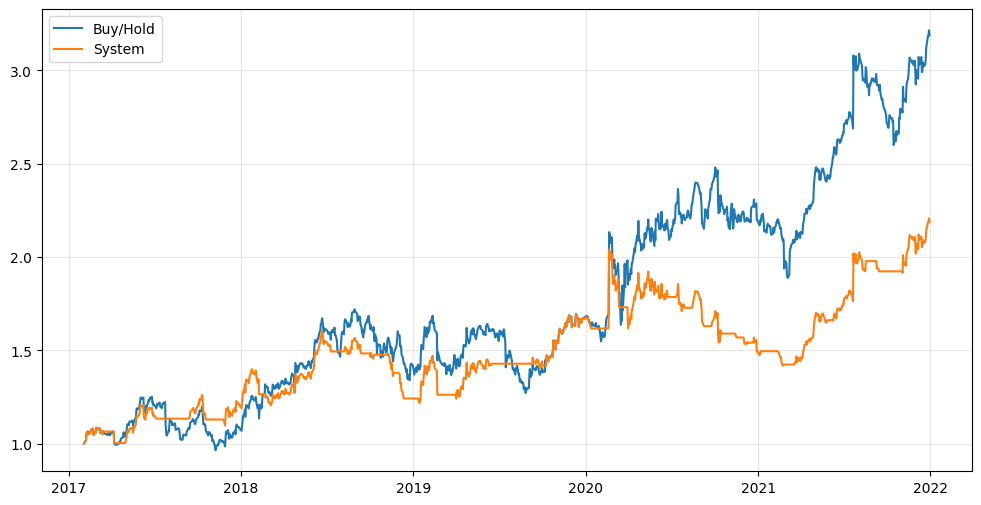

In [ ]:
# Strategy comparison for DPZ stock
plt.plot(np.exp(portfolio_bs1['DPZ-return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(portfolio_bs1['DPZ-system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)
plt.show()

Buy-Hold Strategy VS 8-21 Momentum trading Strategy for QCOM stock
(Data: daily data, Time: 2017-2022)

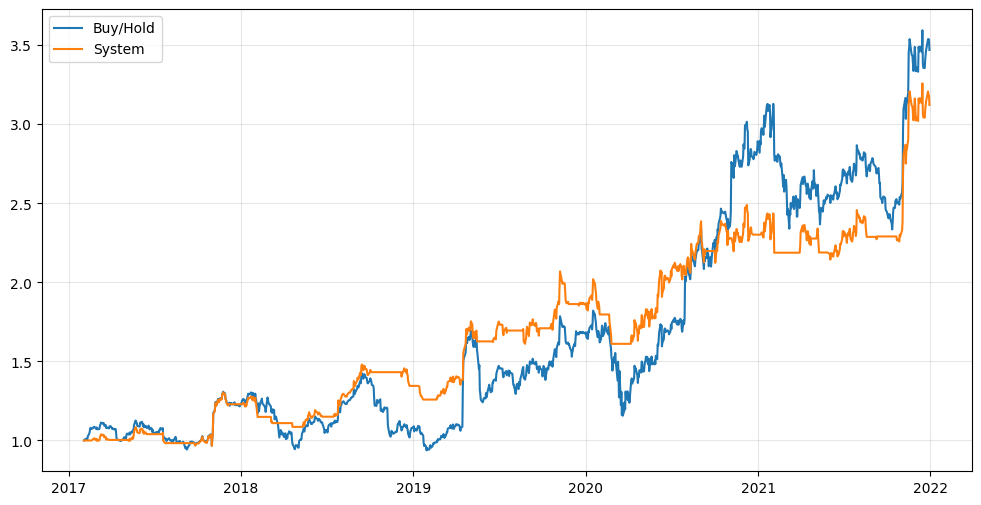

In [ ]:
#Strategy comparison for QCOM stock

plt.plot(np.exp(portfolio_bs1['QCOM-return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(portfolio_bs1['QCOM-system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)
plt.show()

Buy-Hold Strategy VS 8-21 Momentum trading Strategy for NTAP stock
(Data: daily data, Time: 2017-2022)

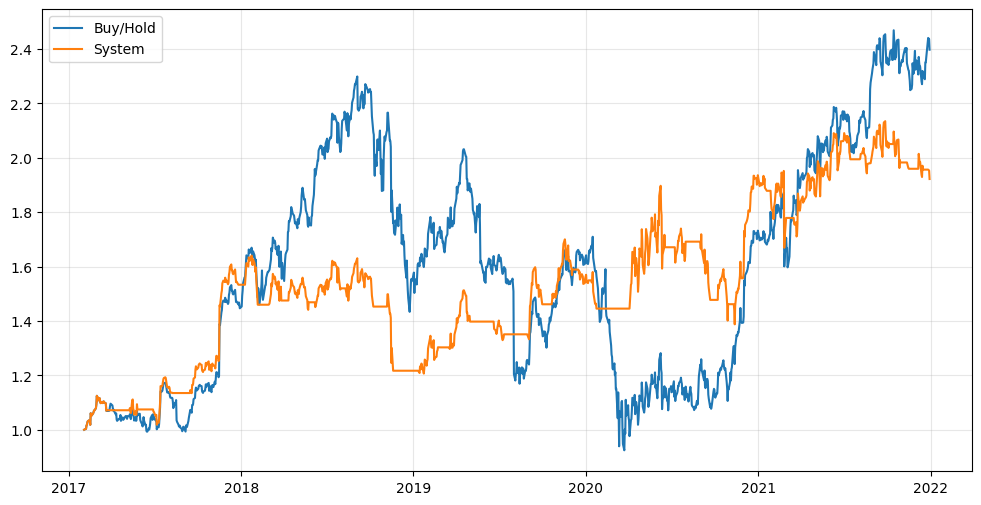

In [ ]:
#Strategy comparison for NTAP stock

plt.plot(np.exp(portfolio_bs1['NTAP-return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(portfolio_bs1['NTAP-system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)
plt.show()

Here we are checking how much amount  are being left with for every strategy

In [ ]:
DPZ_proportion =  0.265779
QCOM_proportion = 0.734169
NTAP_proportion = 0.000027

# Buy-Hold:

#Month wise, year 2022

monthwise DPZ return from buy hold strategy is 0.07014843234601398

monthwise QCOM return from buy hold strategy is -0.3479104006315372

monthwise NTAp return from buy hold strategy is -0.13863171423086795

#Daily, years 2017-2021
DPZ return from buy hold strategy is 2.4389925849548915

QCOM return from buy hold strategy is 1.8200350971400132

NTAP return from buy hold strategy is 1.5649261928421874

# 8-21 momentum trading, each stock:

monthwise is not possible due to moving avg calculation issue

# Daily, years 2017-2021
Returns from 8-21 momentum trading strategy for DPZ stock is 1.3213102241050678

Returns from 8-21 momentum trading strategy for QCOM stock is 0.8711072847345422

Returns from 8-21 momentum trading strategy for NTAP stock is 0.893625998062598

# 8-21 momentum trading, whole MPT:

monthwise is not possible due to moving avg calculation issue

# Daily, years 2017-2021

Returns from 8-21 momentum trading strategy for entire MPT portfolio 2.2905231756910194

# Buy-Hold on S&P 500:

# Monthly only for years 2022
Returns on S&P 500 for monthly data only in the year 2022 is  -0.09643115813130887

# Daily, years 2017-2021
Returns on S&P 500 for monthly data for the years 2017-2021 is  1.1165144475518782

When in Buy-Hold Strategy, monthwise for only year 2022



In [ ]:
investment = 100000

In [ ]:
Return_from_DPZ_mbh = investment * DPZ_proportion * 0.07014843234601398
Return_from_QCOM_mbh = investment * QCOM_proportion * (-0.3479104006315372)
Return_from_NTAP_mbh = investment * NTAP_proportion * (-0.13863171423086795)

print('We will have the following money when invested 100,000 using Buy-Hold Strategy, monthwise for only year 2022 for DPZ, QCOM and NTAP respectively as',Return_from_DPZ_mbh,Return_from_QCOM_mbh,Return_from_NTAP_mbh)

We will have the following money when invested 100,000 using Buy-Hold Strategy, monthwise for only year 2022 for DPZ, QCOM and NTAP respectively as 1864.3980200491249 -25542.503092125502 -0.3743056284233434


In [ ]:
print('Total money left after our returns',investment + Return_from_DPZ_mbh + Return_from_QCOM_mbh + Return_from_NTAP_mbh)

Total money left after our returns 76321.5206222952


When in Buy-Hold Strategy, daily for the years 2017-2021




In [ ]:
Return_from_DPZ_dbh = investment * DPZ_proportion * 2.0056697661107927
Return_from_QCOM_dbh = investment * QCOM_proportion * 2.573448706338041
Return_from_NTAP_dbh = investment * NTAP_proportion * 2.298245614035089

print('We will have the following money when invested 100,000 using Buy-Hold Strategy, monthwise for only year 2022 for DPZ, QCOM and NTAP respectively as',Return_from_DPZ_dbh,Return_from_QCOM_dbh,Return_from_NTAP_dbh)

We will have the following money when invested 100,000 using Buy-Hold Strategy, monthwise for only year 2022 for DPZ, QCOM and NTAP respectively as 53306.49047671603 188934.6263283493 6.20526315789474


In [ ]:
print('Total money left after our returns',investment + Return_from_DPZ_dbh + Return_from_QCOM_dbh + Return_from_NTAP_dbh)

Total money left after our returns 342247.3220682232


When in 8-21 momentum trading, each stock, daily for the years 2017-2021


In [ ]:
Return_from_DPZ_d821 = investment * DPZ_proportion * 1.3213102241050678
Return_from_QCOM_d821 = investment * QCOM_proportion * 0.8711072847345422
Return_from_NTAP_d821 = investment * NTAP_proportion * 0.893625998062598

print('We will have the following money when invested 100,000 using 8-21 momentum trading Strategy, daily for the years 2017-2021 for DPZ, QCOM and NTAP respectively as',Return_from_DPZ_d821,Return_from_QCOM_d821,Return_from_NTAP_d821)

We will have the following money when invested 100,000 using 8-21 momentum trading Strategy, daily for the years 2017-2021 for DPZ, QCOM and NTAP respectively as 35117.65100524208 63953.996412627406 2.4127901947690145


In [ ]:
print('Total money left after our returns',investment + Return_from_DPZ_d821 + Return_from_QCOM_d821 + Return_from_NTAP_d821)

Total money left after our returns 199074.06020806424


When in 8-21 momentum trading, for whole MPT, daily for the years 2017-2022


In [ ]:
Return_from_all = investment * 2.2905231756910194
print('We will have the following money when invested 100,000 using 8-21 momentum trading strategy, daily for the year 2017-2022 for all the stocks as',Return_from_all)

We will have the following money when invested 100,000 using 8-21 momentum trading strategy, daily for the year 2017-2022 for all the stocks as 229052.31756910193


In [ ]:
print('Total money left after our returns',investment + Return_from_all)

Total money left after our returns 329052.3175691019


When in Buy-Hold on S&P500, month wise for only year 2022

In [ ]:
Return_from_all_msp = investment * -0.09643115813130887
print('We will have the following money when invested 100,000 using S&P 500 Strategy, month wise only for year 2022 for all the stocks as',Return_from_all_msp)

We will have the following money when invested 100,000 using S&P 500 Strategy, month wise only for year 2022 for all the stocks as -9643.115813130888


In [ ]:
print('Total money left after our returns',investment + Return_from_all_msp)

Total money left after our returns 90356.88418686911


When in Buy-Hold on S&P500, daily for the years 2017-2022

In [ ]:
Return_from_all_dsp = investment * 1.1165144475518782
print('We will have the following money when invested 100,000 using S&P 500 Strategy, daily only for years 2017-2022 for all the stocks as',Return_from_all_dsp)

We will have the following money when invested 100,000 using S&P 500 Strategy, daily only for years 2017-2022 for all the stocks as 111651.44475518783


In [ ]:
print('Total money left after our returns',investment + Return_from_all_dsp)

Total money left after our returns 211651.44475518784


## 3.6 - Discussion and Comparison of the Investment Strategies


### If we have $100,000 we would divide this amount into 3 stocks in this proportion using Optimal Portfolio Allocation.



*   Invest 3,930 into DPZ stock.
*   Invest 21,900 into QCOM stock.
*   Invest 74,100 into NTAP stock.

•	Using the Buy and Hold strategy, the investment made on DPZ stock would have skyrocketed by an astounding 200%, QCOM stock would have yielded an impressive 257% increase, and overall, NTAP stock would have surged by a staggering 229%.

•	Alternatively, if the Momentum Trading strategy was employed, DPZ stock would have increased by a still impressive 132%, while QCOM and NTAP stock would have yielded returns of 87% and 89% respectively.

•	Thus, we strongly recommend the Buy & Hold strategy for long-term investments to generate maximum returns.

•	However, for short-term investments, the Momentum trading strategy proved to be the most profitable. By leveraging technical indicators and making prompt buy and sell decisions, it yielded substantial returns.

•	By contrast, investing in the S&P 500 Index would have yielded 111% on returns Awhich is lower when compared to. Buy & Hold strategies.

•	Similarly, investing in the 8-21 MPT portfolio would have resulted in lower returns as well when compared to Buy & Hold strategy.















# 4 - Conclusion

## 4.1 - Thoughts and Insights

#### 1. Investing in a particular sector will draw down the account balance and can lead to losses when a scenario like recession comes. Instead, diversifying the portfolio and investing in multiple sectors can save money. But, in the case of a diversified portfolio, returns and risks are both moderate.

#### 2. Using trading indicators such as Momentum Trading (9-day vs 21-day) can help us make investment decisions that are efficient investments with an appropriate amount of risk.

#### 3. Investing in blue chip companies could provide a wonderful return in an upward trending market. However, in a volatile environment with a downward trend, they appear to lose high value compared to their low beta peers.

#### 4. Modern Portfolio Theory (MPT): Our selection of 3 stocks was inspired by MPT theory and efficient frontier. Specifically, we analyzed the curve for optimal risk-return and chose a risk level of 0.03%, after which the slope of the curve started flattening. The case of marginal diminishing return was very evident, and it inspired us to devise the portfolio with optimal risk. A portfolio devised based on MPT could help an investor to get better risk-adjusted results.

#### 5. If a person can identify a decent risk-management strategy, they could protect the portfolio from a larger decline. For example, the strategy of selling stocks where 9 day MA goes below 21 day MA would have really helped an investor to protect the value of the portfolio by staying out of the market.

#### 6. In the optimization model, the allocation changes for the given risk tolerance. For a lower risk tolerance, the portfolio would be more diversified and for the case of a higher risk tolerance the portfolio would be less diversified.

#### 7. In a side trend markets, the accuracy of Momentum Trading strategies is lower. Its accuracy is higher in upward trending and downward trending markets.
